# Control investigations

* Compare peak calling results without / with peaks
* Swap control
* Minimize control size in pairs of replicates ENCODE
* Downscale Roadmap control size 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile
import math

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks

1. Create dataset without control tracks
2. Launch peak calling

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=False sicer=False --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=False span=True sicer=True --rerun-trigger mtime;
```


In [3]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_NO_CONTROL_PATH = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_NO_CONTROL_PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

/tmp/ipykernel_681029/386494431.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10')


In [5]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [6]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    if len(df_sicer) == 0:
        df_sicer = load_peaks(os.path.join(path, 'sicer'), 'E100.scoreisland', modifications, cells, replicates) 
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [7]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks['control'] = True

df_encode_no_control_peaks = load_peaks_path(GSE26320_NO_CONTROL_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_no_control_peaks['dataset'] = 'ENCODE'
df_encode_no_control_peaks['control'] = False

df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks['control'] = True

df_immune_no_control_peaks = load_peaks_path(IMMUNE_NO_CONTROL_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_no_control_peaks['dataset'] = 'Roadmap'
df_immune_no_control_peaks['control'] = False

df_peaks_full = pd.concat([df_encode_peaks, df_encode_no_control_peaks, 
                      df_immune_peaks, df_immune_no_control_peaks]).reset_index(drop=True)
df_peaks_full.sample(3)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/405 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/342 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/219 [00:00<?, ?it/s]

SPAN 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/187 [00:00<?, ?it/s]

SPAN 46


,file,modification,cell,replicate,peaks,tool,dataset,control
357,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K36me3,HMEC,rep1,36,MACS2,ENCODE,False
346,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K4me3,HSMM,rep1,26154,MACS2,ENCODE,False
523,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K36me3,HepG2,rep1,34956,SICER,ENCODE,False


ENCODE


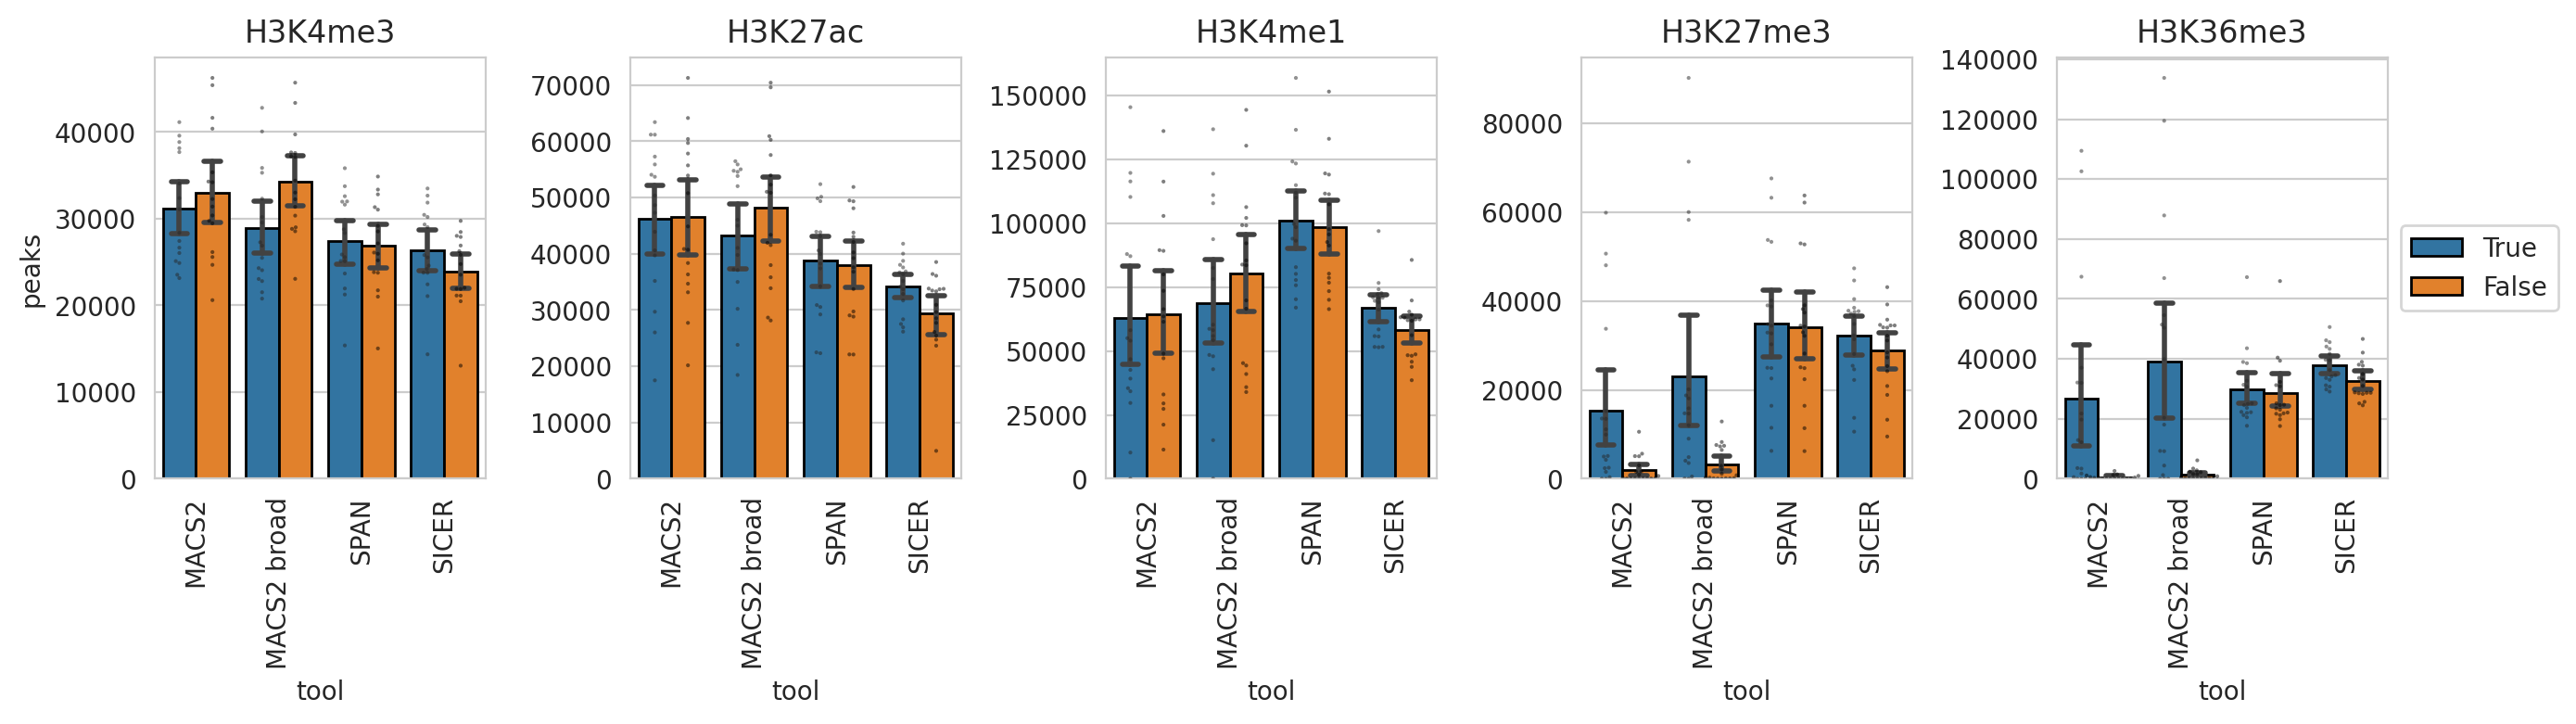

Roadmap


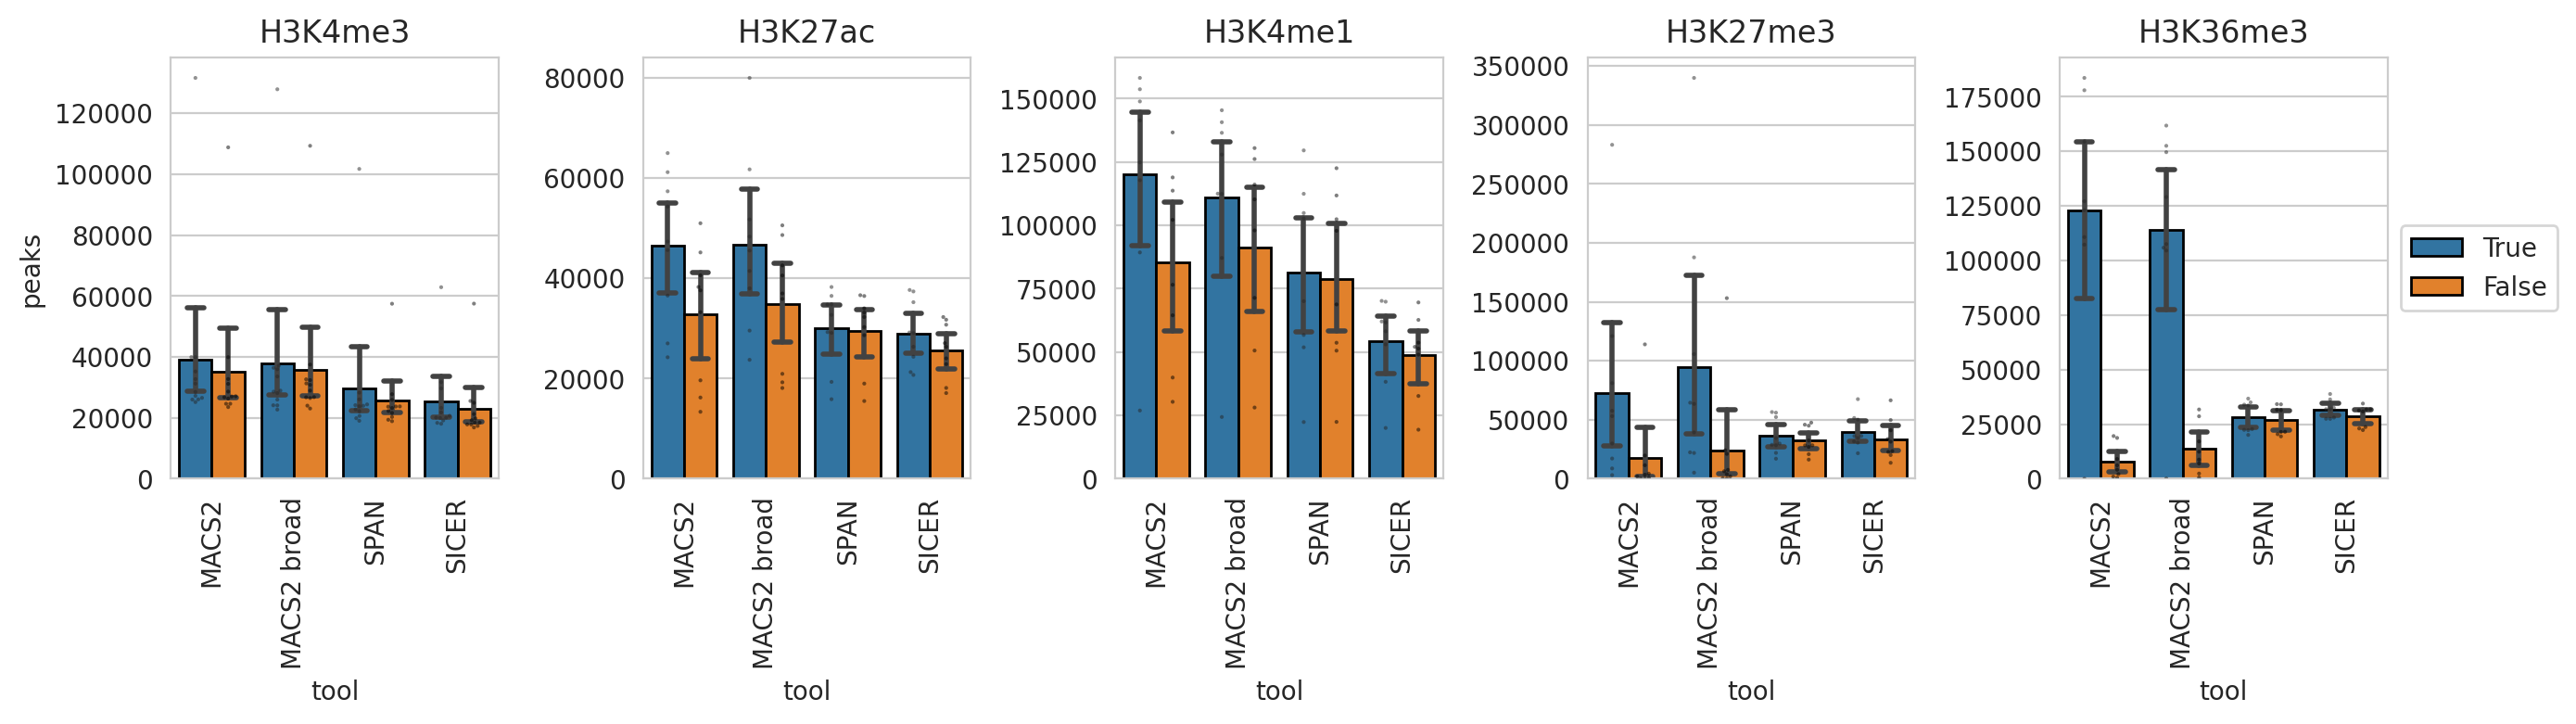

In [8]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(14, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.barplot(data=df_peaks_full[(df_peaks_full['dataset'] == ds) & 
                                  (df_peaks_full['modification'] == m)], x='tool', y='peaks', hue='control',
                    capsize=.2, errwidth=2, edgecolor="black",
                    order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                    hue_order=[True, False],
                    ax=ax,)
        sns.swarmplot(data=df_peaks_full[(df_peaks_full['dataset'] == ds) &
                                    (df_peaks_full['modification'] == m)], x='tool', y='peaks', hue='control',
                      dodge=True, size=1.5, color="black", alpha=0.5, palette='dark:black',
                      order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                      hue_order=[True, False],
                      ax=ax)

        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('peaks')
        if i < 4:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # ax.set_ylim(0, 1.9e7)
    plt.tight_layout()
    # plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [9]:
df_peaks_full[(df_peaks_full['tool'] == 'SPAN') & (df_peaks_full['modification'] == 'H3K27me3') & (df_peaks_full['peaks'] > 100_000)]

,file,modification,cell,replicate,peaks,tool,dataset,control


In [10]:
# Remove outliers, see 2023 - figures.ipynb
OUTLIERS = [
    ('H3K4me3', 'NK', ''),
    ('H3K27me3', 'TCell', ''),
    ('H3K27me3', 'BCell', ''),
]
df_peaks = df_peaks_full.loc[[(m, c, r) not in OUTLIERS
                              for _, (m, c, r) in df_peaks_full[['modification', 'cell', 'replicate']].iterrows()]].copy()
df_peaks.sample(3)

,file,modification,cell,replicate,peaks,tool,dataset,control
344,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K4me3,GM12878,rep1,24681,MACS2,ENCODE,False
292,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K4me1,HSMM,rep2,124173,SPAN,ENCODE,True
76,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K36me3,NHLF,rep1,3,MACS2,ENCODE,True


ENCODE


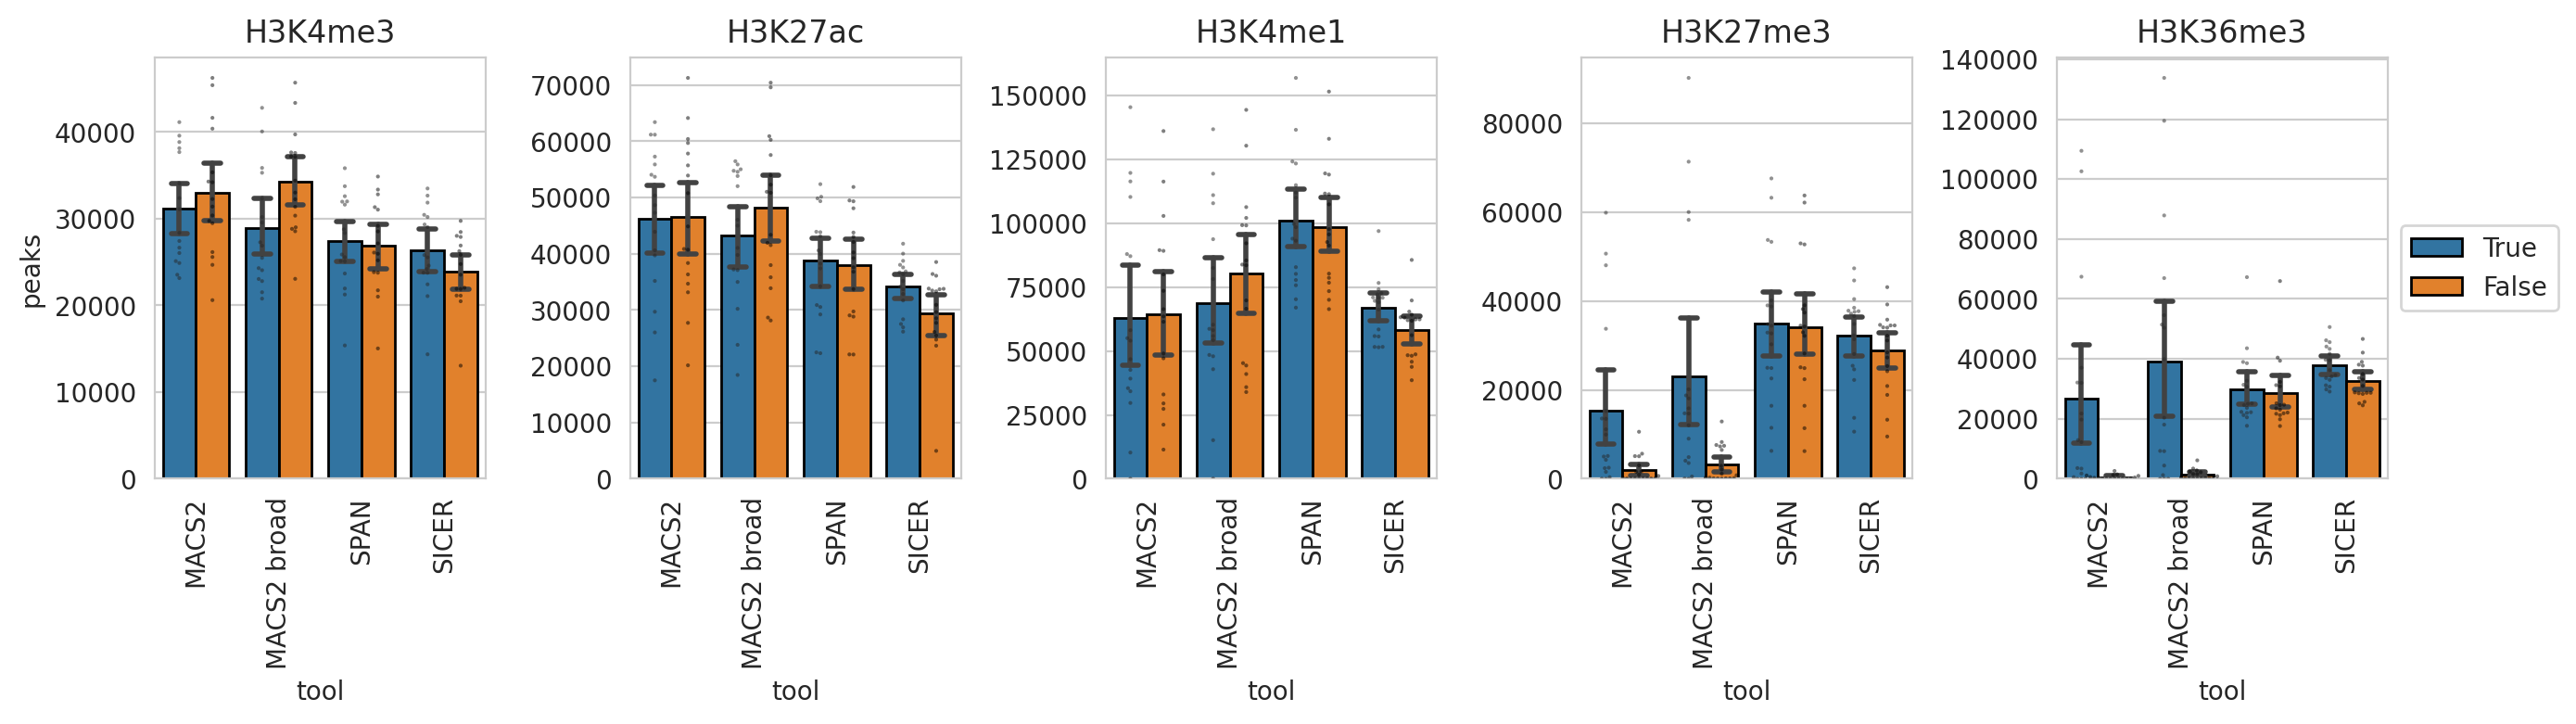

Roadmap


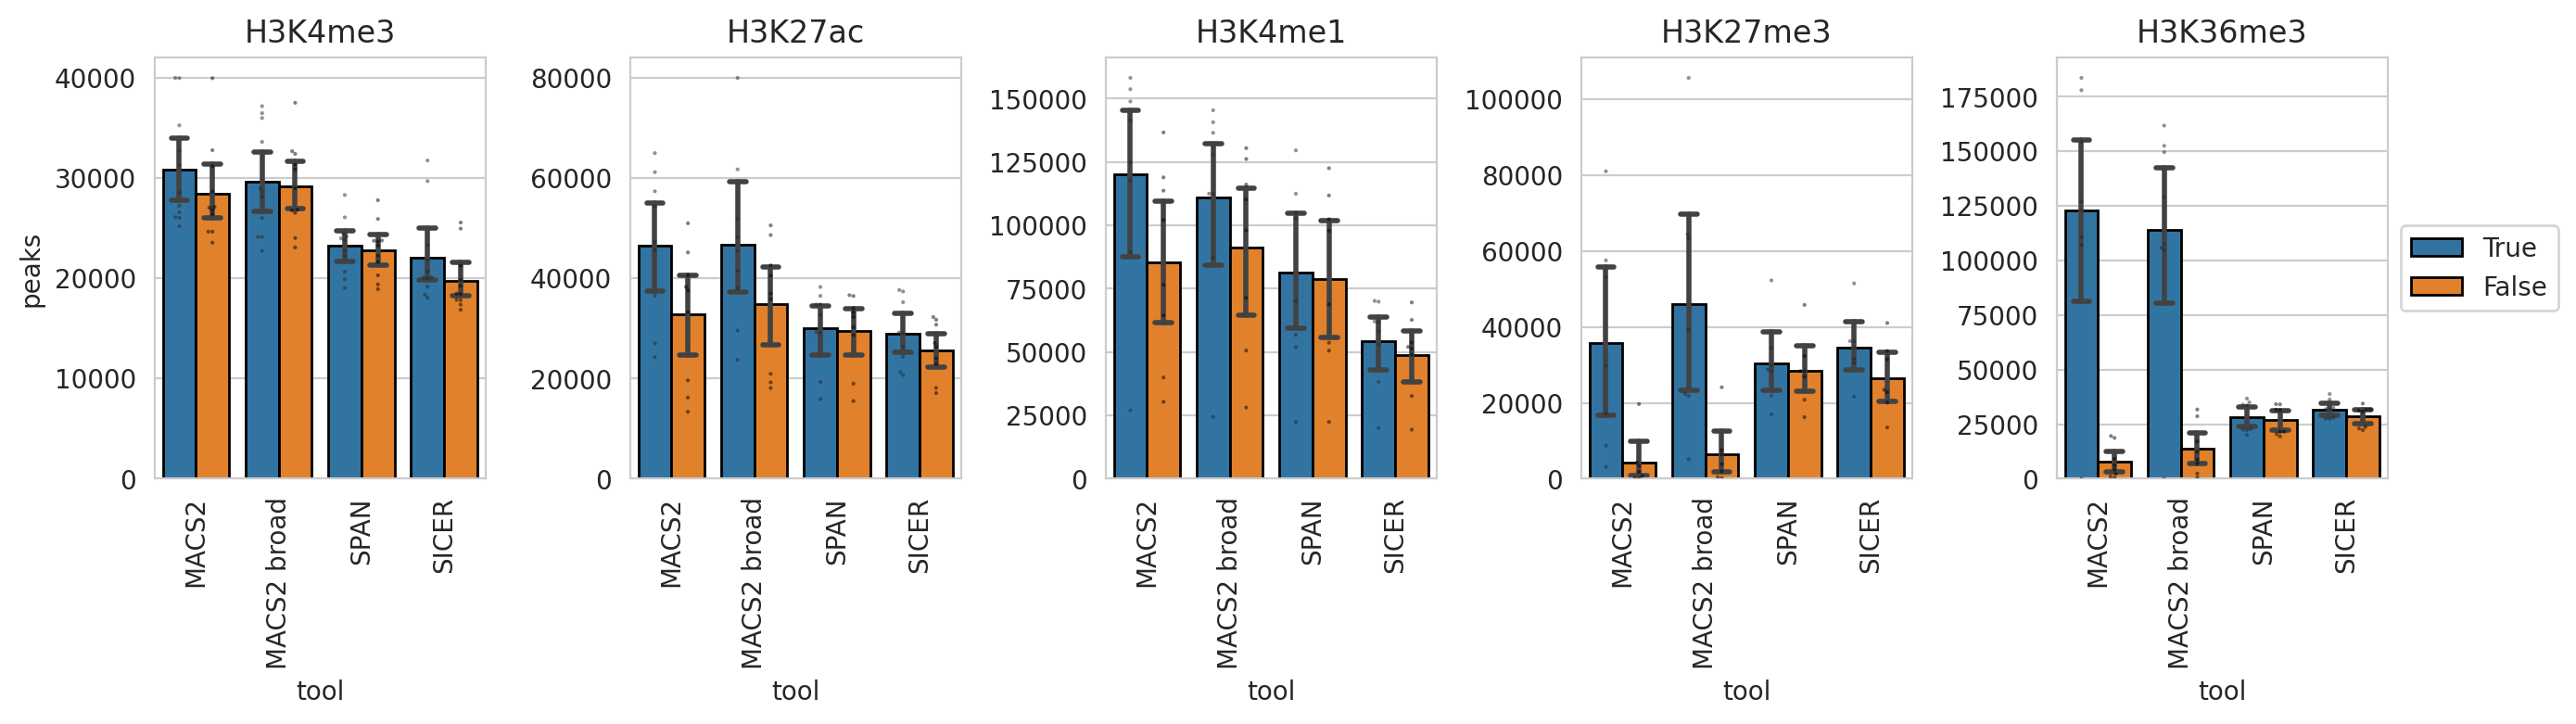

In [11]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(14, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.barplot(data=df_peaks[(df_peaks['dataset'] == ds) &
                                  (df_peaks['modification'] == m)], x='tool', y='peaks', hue='control',
                    capsize=.2, errwidth=2, edgecolor="black",
                    order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                    hue_order=[True, False],
                    ax=ax,)
        sns.swarmplot(data=df_peaks[(df_peaks['dataset'] == ds) &
                                    (df_peaks['modification'] == m)], x='tool', y='peaks', hue='control',
                      dodge=True, size=1.5, color="black", alpha=0.5, palette='dark:black',
                      order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                      hue_order=[True, False],
                      ax=ax)

        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('peaks')
        if i < 4:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # ax.set_ylim(0, 1.9e7)
    plt.tight_layout()
    # plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
    plt.show()

NO CONTROL


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWar

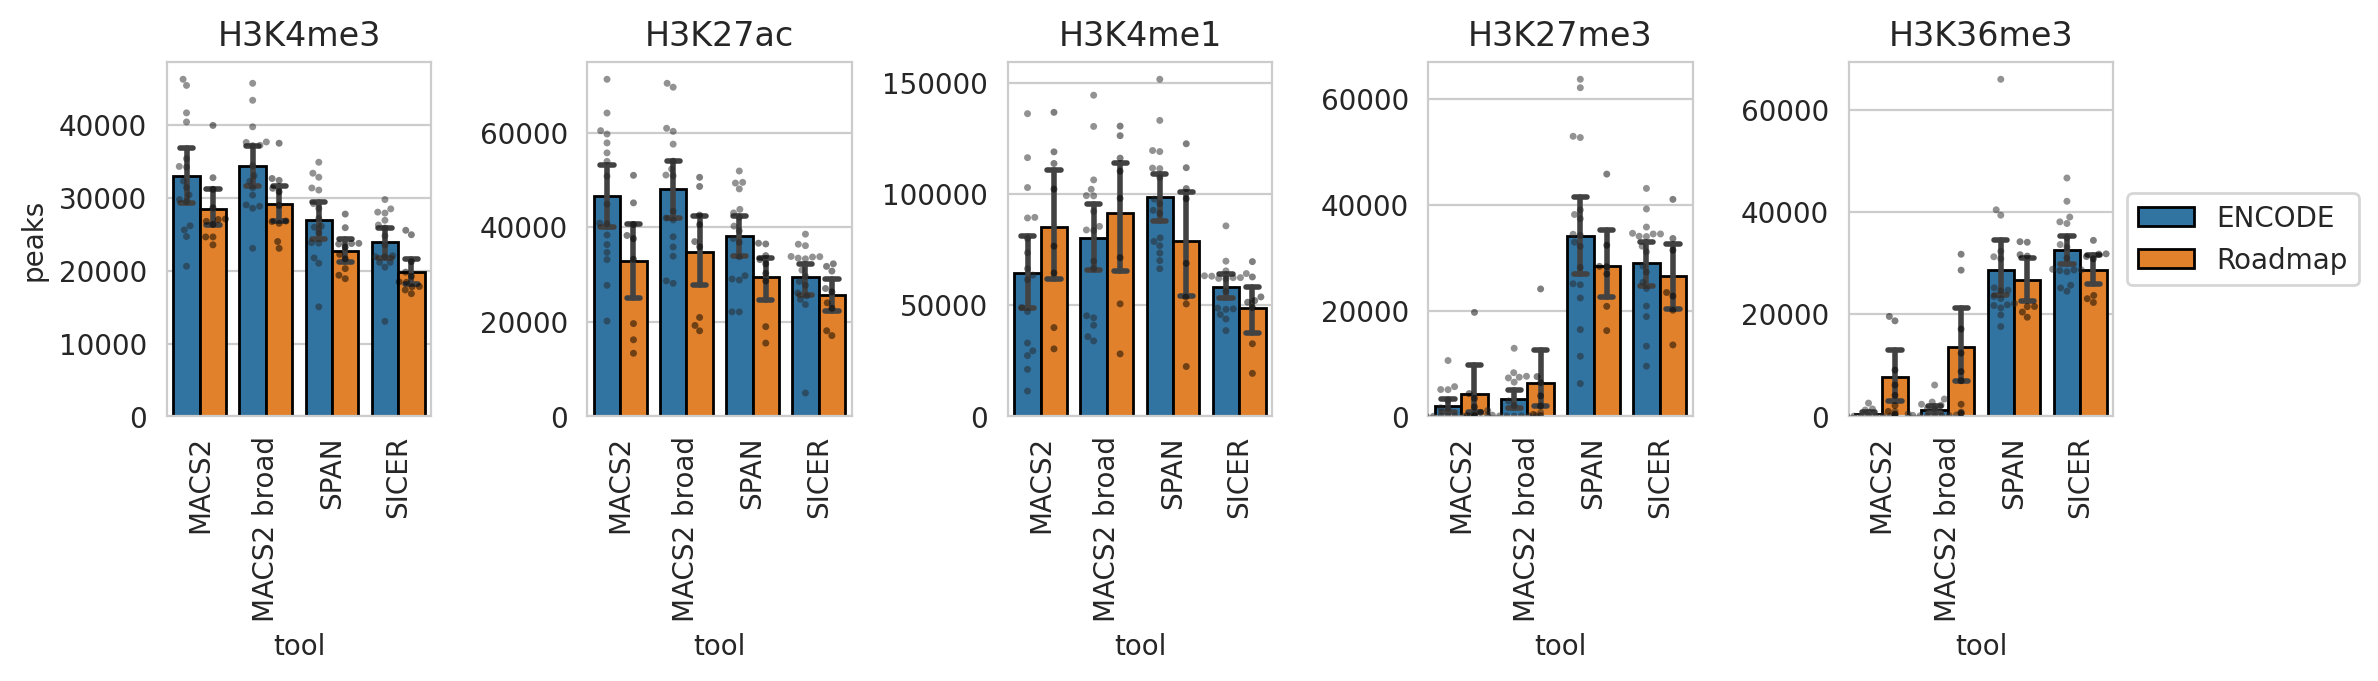

In [12]:
print('NO CONTROL')
plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[(df_peaks['modification'] == m) & (df_peaks['control'] == False)], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.swarmplot(data=df_peaks[(df_peaks['modification'] == m) & (df_peaks['control'] == False)], x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=2.5, palette='dark:black', alpha=0.5, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) -1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Compute ratio no control vs control

In [13]:
rows = []
for (ds, m, c, r, t), dft in tqdm(df_peaks.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool'])):
    if len(dft) == 2:
        print(ds, m, c, r, t)
        if len(dft[dft['control'] == True]) != 1 or len(dft[dft['control'] == False]) != 1:
            continue
        with_control = dft[dft['control'] == True]['file'].values[0]
        without_control = dft[dft['control'] == False]['file'].values[0]
        peaks_with_control = lines(with_control)
        peaks_without_control = lines(without_control)
        rows.append((ds, m, c, r, t, d(peaks_without_control, peaks_with_control)))
df_ratio = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool', 'ratio'])
df_ratio['ratio'] = ((df_ratio['ratio'] - 1) * 100).astype(int)
del rows
df_ratio.sample(3)

  0%|          | 0/512 [00:00<?, ?it/s]

ENCODE H3K27ac GM12878 rep1 MACS2
ENCODE H3K27ac GM12878 rep1 MACS2 broad
ENCODE H3K27ac GM12878 rep1 SICER
ENCODE H3K27ac GM12878 rep1 SPAN
ENCODE H3K27ac GM12878 rep2 MACS2
ENCODE H3K27ac GM12878 rep2 MACS2 broad
ENCODE H3K27ac GM12878 rep2 SICER
ENCODE H3K27ac GM12878 rep2 SPAN
ENCODE H3K27ac H1 rep1 MACS2
ENCODE H3K27ac H1 rep1 MACS2 broad
ENCODE H3K27ac H1 rep1 SICER
ENCODE H3K27ac H1 rep1 SPAN
ENCODE H3K27ac HMEC rep1 MACS2
ENCODE H3K27ac HMEC rep1 MACS2 broad
ENCODE H3K27ac HMEC rep1 SICER
ENCODE H3K27ac HMEC rep1 SPAN
ENCODE H3K27ac HMEC rep2 MACS2
ENCODE H3K27ac HMEC rep2 MACS2 broad
ENCODE H3K27ac HMEC rep2 SICER
ENCODE H3K27ac HMEC rep2 SPAN
ENCODE H3K27ac HSMM rep1 MACS2
ENCODE H3K27ac HSMM rep1 MACS2 broad
ENCODE H3K27ac HSMM rep1 SICER
ENCODE H3K27ac HSMM rep1 SPAN
ENCODE H3K27ac HSMM rep2 MACS2
ENCODE H3K27ac HSMM rep2 MACS2 broad
ENCODE H3K27ac HSMM rep2 SICER
ENCODE H3K27ac HSMM rep2 SPAN
ENCODE H3K27ac HepG2 rep1 MACS2
ENCODE H3K27ac HepG2 rep1 MACS2 broad
ENCODE H3K2

,dataset,modification,cell,replicate,tool,ratio
108,ENCODE,H3K27me3,Huvec,rep1,MACS2,-90
427,Roadmap,H3K36me3,Monocyte,,SPAN,-3
131,ENCODE,H3K27me3,NHEK,rep2,SPAN,-1


In [14]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

/tmp/ipykernel_681029/386494431.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10')


ENCODE


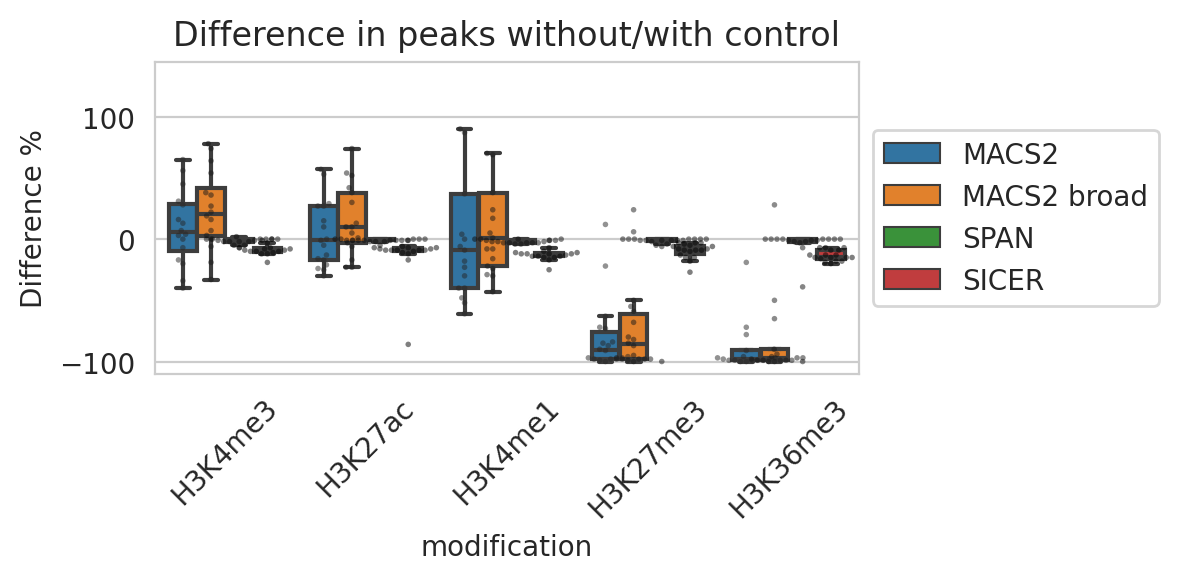

Roadmap


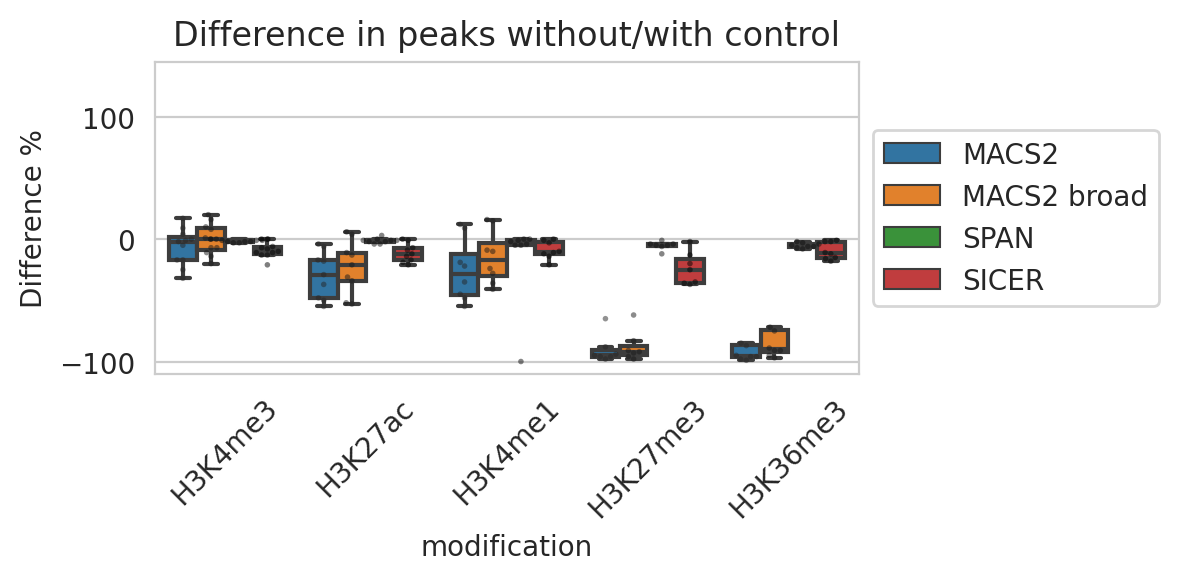

In [15]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(6, 3))
    ax = plt.axes()
    sns.boxplot(data=df_ratio[df_ratio['dataset'] == ds],
                x='modification', y='ratio', hue='tool',
                showfliers=False,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                palette = TOOLS_PALETTE,
                ax=ax)
    sns.swarmplot(data=df_ratio[df_ratio['dataset'] == ds],
                  x='modification', y='ratio', hue='tool',
                  dodge=True, size=2, color="black", alpha=0.5, palette='dark:black',
                  order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                  hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)
    ax.set_ylabel('Difference %')
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylim(-110, 145)
    ax.set_title('Difference in peaks without/with control')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [16]:
df_ratio[(df_ratio['dataset'] == 'ENCODE') & (df_ratio['tool'] == 'SPAN') & 
         (df_ratio['modification'] == 'H3K27me3') & (df_ratio['ratio'] > 90)]

,dataset,modification,cell,replicate,tool,ratio


ENCODE + Roadmap


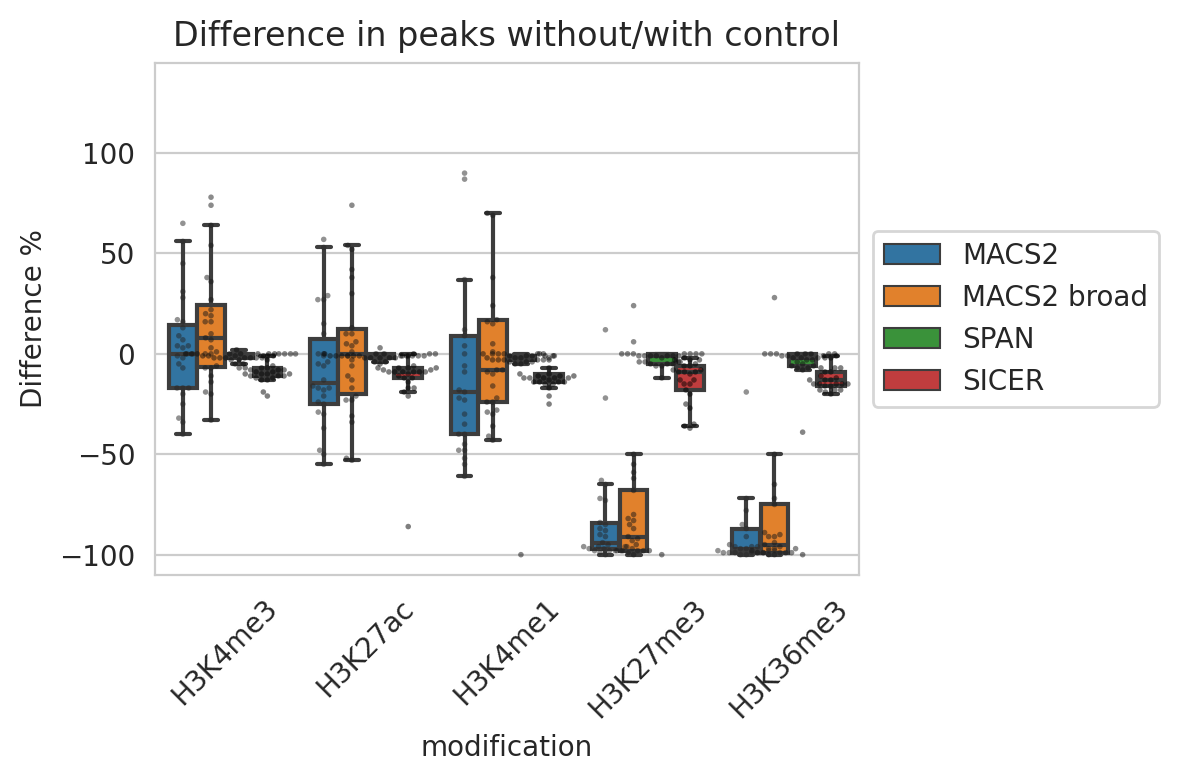

In [17]:
print('ENCODE + Roadmap')
plt.figure(figsize=(6, 4))
ax = plt.axes()
sns.boxplot(data=df_ratio,
            x='modification', y='ratio', hue='tool',
            showfliers=False,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            palette = TOOLS_PALETTE,
            ax=ax)
sns.swarmplot(data=df_ratio,
              x='modification', y='ratio', hue='tool',
              dodge=True, size=2, alpha=0.5,
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              palette='dark:black',
              ax=ax)
ax.set_ylabel('Difference %')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylim(-110, 145)
ax.set_title('Difference in peaks without/with control')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE + Roadmap NO SPAN


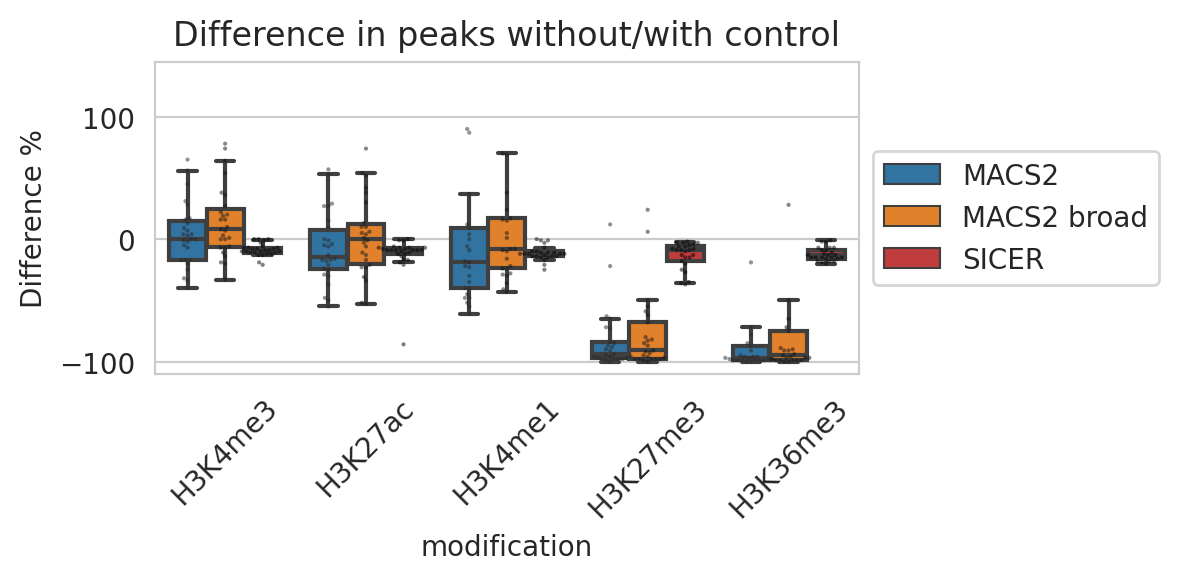

In [18]:
print('ENCODE + Roadmap NO SPAN')
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=df_ratio,
            x='modification', y='ratio', hue='tool',
            showfliers=False,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
            hue_order=['MACS2', 'MACS2 broad', 'SICER'],
            palette = TOOLS_PALETTE,
            ax=ax)
sns.swarmplot(data=df_ratio,
              x='modification', y='ratio', hue='tool',
              dodge=True, size=1.5, alpha=0.5,
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
              hue_order=['MACS2', 'MACS2 broad', 'SICER'], legend=False,
              palette='dark:black',
              ax=ax)
ax.set_ylabel('Difference %')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylim(-110, 145)
ax.set_title('Difference in peaks without/with control')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Jaccard without control vs with control

In [19]:
tf = tempfile.mktemp()
rows = []
for (ds, m, c, r, t), dft in tqdm(df_peaks.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool'])):
    if len(dft) == 2:
        with_control = sorted_file(dft[dft['control'] == True]['file'].values[0])
        without_control = sorted_file(dft[dft['control'] == False]['file'].values[0])
        peaks_with_control = lines(with_control)
        peaks_without_control = lines(without_control)
        len_with_control = bedl(with_control).sum()
        len_without_control = bedl(without_control).sum()
        !bedtools intersect -a {with_control} -b {without_control} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        jaccard = d(overlap_len, len_with_control + len_without_control - overlap_len)
        rows.append((ds, m, c, r, t, peaks_with_control, peaks_without_control, len_with_control, len_without_control, 
                     d(len_with_control, peaks_with_control), d(len_without_control, peaks_without_control),
                     overlap_len, jaccard))
df_jaccard = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool',
                                         'peaks_with_control', 'peaks_without_control',
                                         'len_with_control', 'len_without_control', 
                                         'avg_len_with_control', 'avg_len_without_control',
                                         'overlap_len', 'jaccard'])
del rows
df_jaccard.sample(3)

  0%|          | 0/512 [00:00<?, ?it/s]

,dataset,modification,cell,replicate,tool,peaks_with_control,peaks_without_control,len_with_control,len_without_control,avg_len_with_control,avg_len_without_control,overlap_len,jaccard
439,Roadmap,H3K4me1,BCell,,SPAN,104882,102424,124519210.0,124656309,1187.231460,1217.061519,123121020,0.976728
443,Roadmap,H3K4me1,CD34,,SPAN,129590,122568,138162560.0,141963179,1066.151401,1158.240152,136634370,0.952213
503,Roadmap,H3K4me3,TCell,,SPAN,26057,25894,26774950.0,27181089,1027.553057,1049.706071,26511900,0.966031


ENCODE


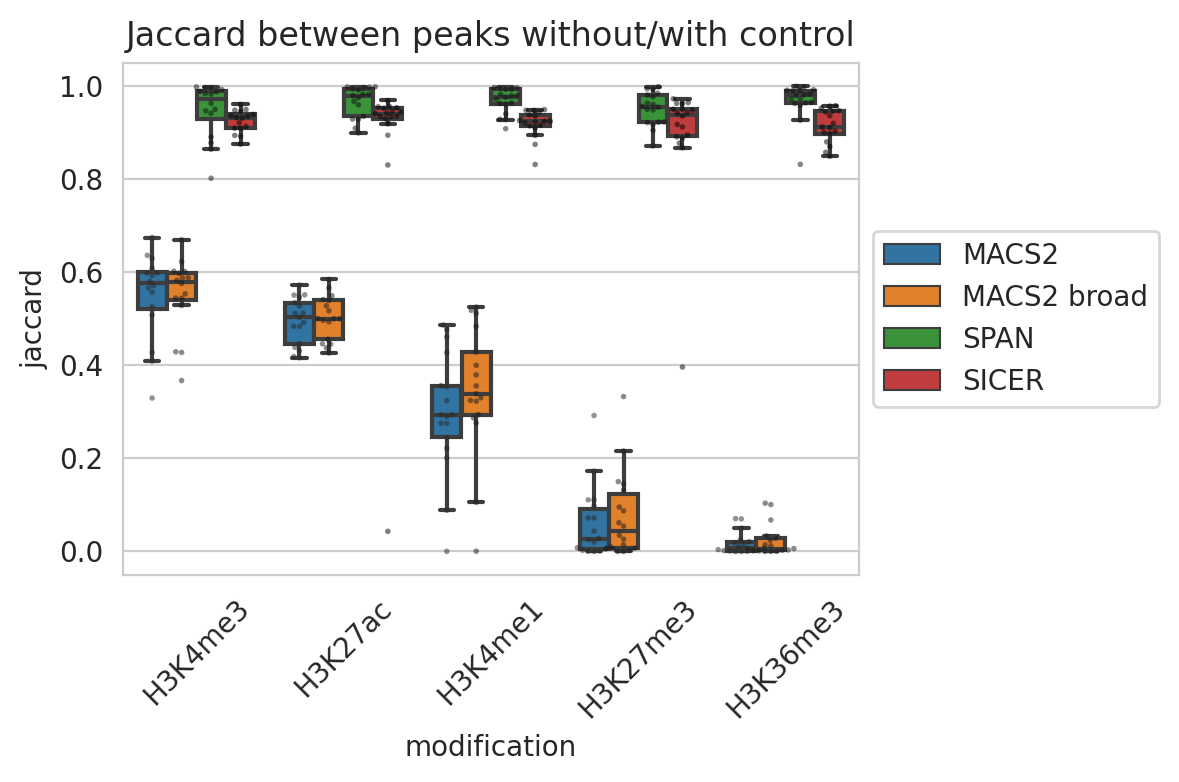

Roadmap


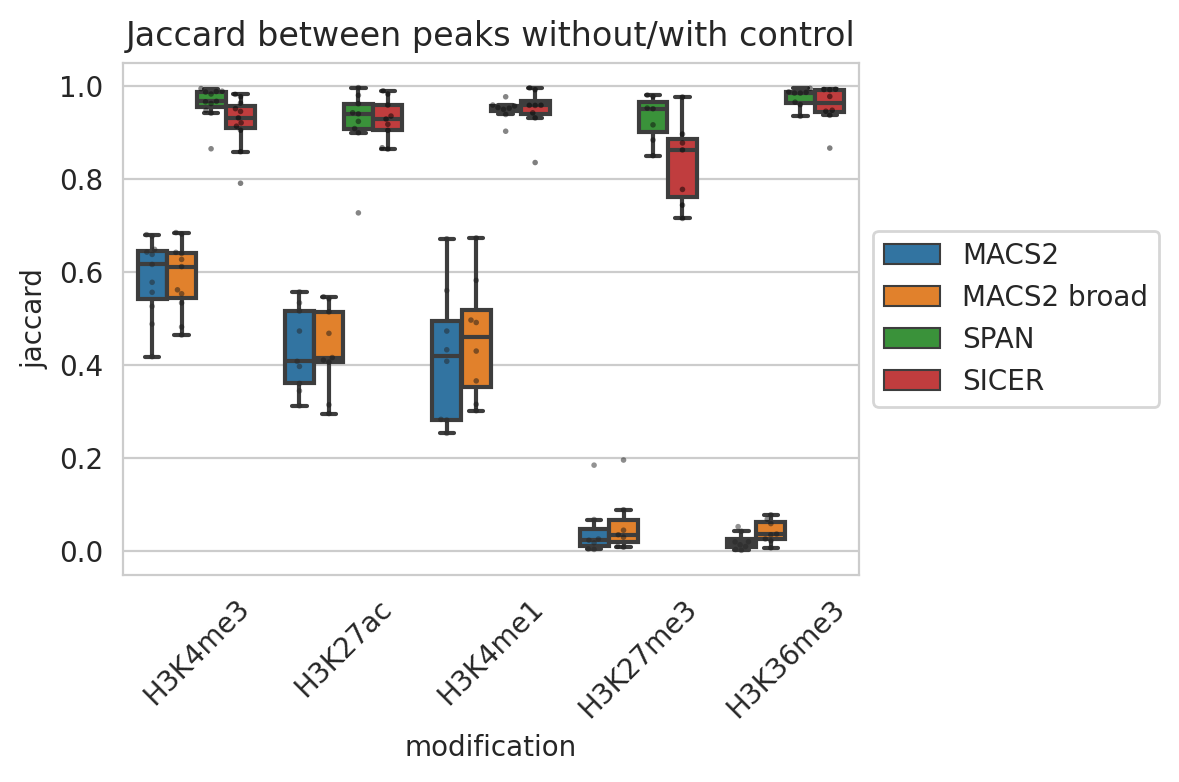

In [20]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(6, 4))
    ax = plt.axes()
    sns.boxplot(data=df_jaccard[df_jaccard['dataset'] == ds],
                x='modification', y='jaccard', hue='tool',
                showfliers=False,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_jaccard[df_jaccard['dataset'] == ds],
                  x='modification', y='jaccard', hue='tool',
                  dodge=True, size=2, color="black", alpha=0.5, palette='dark:black',
                  order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                  hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)
    ax.set_ylabel('jaccard')
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title('Jaccard between peaks without/with control')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [21]:
df_jaccard[(df_jaccard['tool'] == 'SPAN') &
           (df_jaccard['modification'] == 'H3K27me3') & 
           (df_jaccard['jaccard'] < 0.1)]

,dataset,modification,cell,replicate,tool,peaks_with_control,peaks_without_control,len_with_control,len_without_control,avg_len_with_control,avg_len_without_control,overlap_len,jaccard


ENCODE + Roadmap


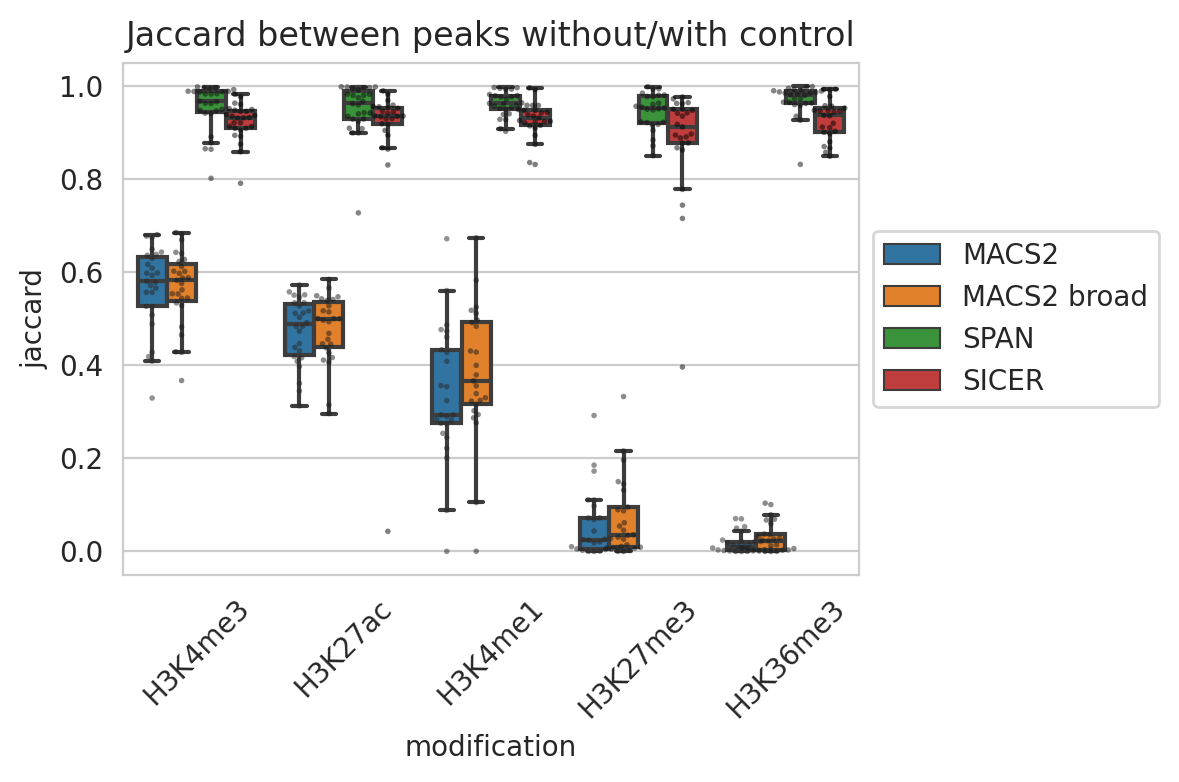

In [22]:
print('ENCODE + Roadmap')
plt.figure(figsize=(6, 4))
ax = plt.axes()
sns.boxplot(data=df_jaccard,
            x='modification', y='jaccard', hue='tool',
            showfliers=False,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=df_jaccard,
              x='modification', y='jaccard', hue='tool',
              dodge=True, size=2, color="black", alpha=0.5, palette='dark:black',
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_ylabel('jaccard')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylim(-0.05, 1.05)
ax.set_title('Jaccard between peaks without/with control')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [23]:
df_jaccard[(df_jaccard['dataset'] == 'Roadmap') & 
         (df_jaccard['modification'] == 'H3K27me3') & 
         (df_jaccard['jaccard'] < 0.2)]

,dataset,modification,cell,replicate,tool,peaks_with_control,peaks_without_control,len_with_control,len_without_control,avg_len_with_control,avg_len_without_control,overlap_len,jaccard
376,Roadmap,H3K27me3,CD34,,MACS2,53084,1819,29118068.0,594207,548.528144,326.666850,545712,0.018710
377,Roadmap,H3K27me3,CD34,,MACS2 broad,64451,3891,45059059.0,1455076,699.121177,373.959393,1383724,0.030661
380,Roadmap,H3K27me3,CD34,rep2,MACS2,81061,4321,70038383.0,1913425,864.020713,442.819949,1868617,0.026663
381,Roadmap,H3K27me3,CD34,rep2,MACS2 broad,105668,7535,105504627.0,3847627,998.453903,510.633975,3792270,0.035925
384,Roadmap,H3K27me3,CD4,,MACS2,3126,113,1004365.0,43409,321.293986,384.150442,4627,0.004436
385,Roadmap,H3K27me3,CD4,,MACS2 broad,5166,179,2053450.0,71059,397.493225,396.977654,23183,0.011033
388,Roadmap,H3K27me3,CD4,rep2,MACS2,8738,148,3386228.0,60751,387.528954,410.479730,18655,0.005441
389,Roadmap,H3K27me3,CD4,rep2,MACS2 broad,21849,387,9943058.0,155111,455.080690,400.803618,90950,0.009088
392,Roadmap,H3K27me3,Monocyte,,MACS2,57580,19683,57137110.0,11086611,992.308267,563.258192,10671995,0.185433
393,Roadmap,H3K27me3,Monocyte,,MACS2 broad,63468,24114,73399321.0,15376599,1156.477611,637.662727,14574441,0.196417


In [24]:
df_jaccard['union_len'] = df_jaccard['len_with_control'] + df_jaccard['len_without_control']  - df_jaccard['overlap_len']
df_jaccard['overlap_diff'] = df_jaccard['len_with_control'] + df_jaccard['len_without_control']  - 2 * df_jaccard['overlap_len']

ENCODE


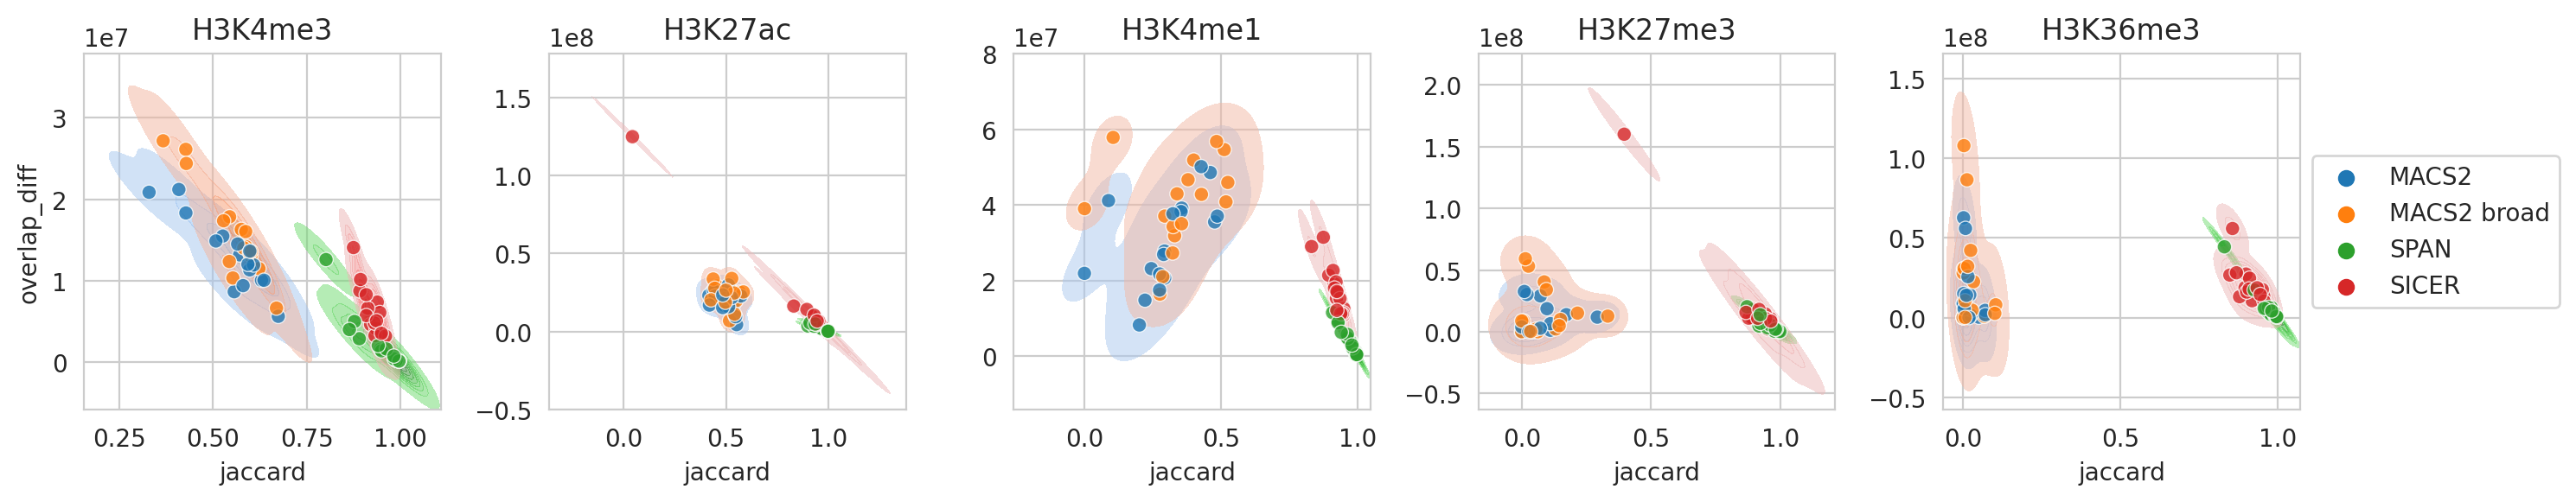

Roadmap


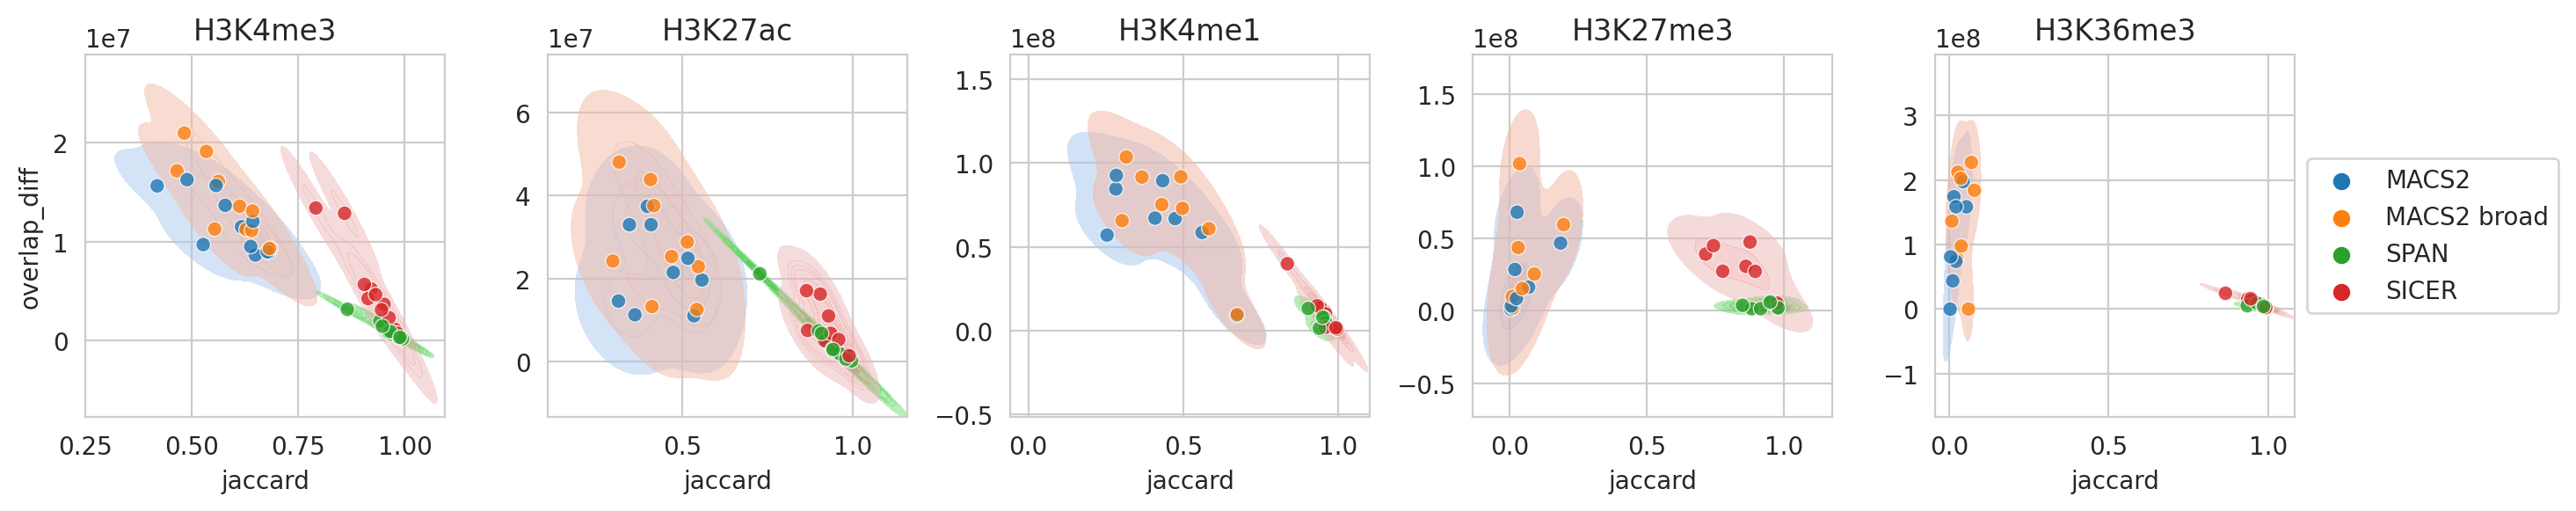

In [25]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.kdeplot(df_jaccard[(df_jaccard['dataset'] == ds) &
                               (df_jaccard['modification'] == m)],
                    palette=TOOLS_PALETTE,
                    hue_order=TOOLS,
                    x='jaccard', y='overlap_diff', hue='tool', 
                    alpha=0.5,
                    thresh=0.01,
                    fill=True,
                    legend=False,
                    ax = ax)
        sns.scatterplot(df_jaccard[(df_jaccard['dataset'] == ds) &
                                   (df_jaccard['modification'] == m)],
                        palette=TOOLS_PALETTE,
                        hue_order=TOOLS,
                        x='jaccard', y='overlap_diff', hue='tool', alpha=0.8,
                        ax = ax)
        ax.set_title(m)
        if i > 0:
            ax.set_ylabel(None)
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

ENCODE + Roadmap


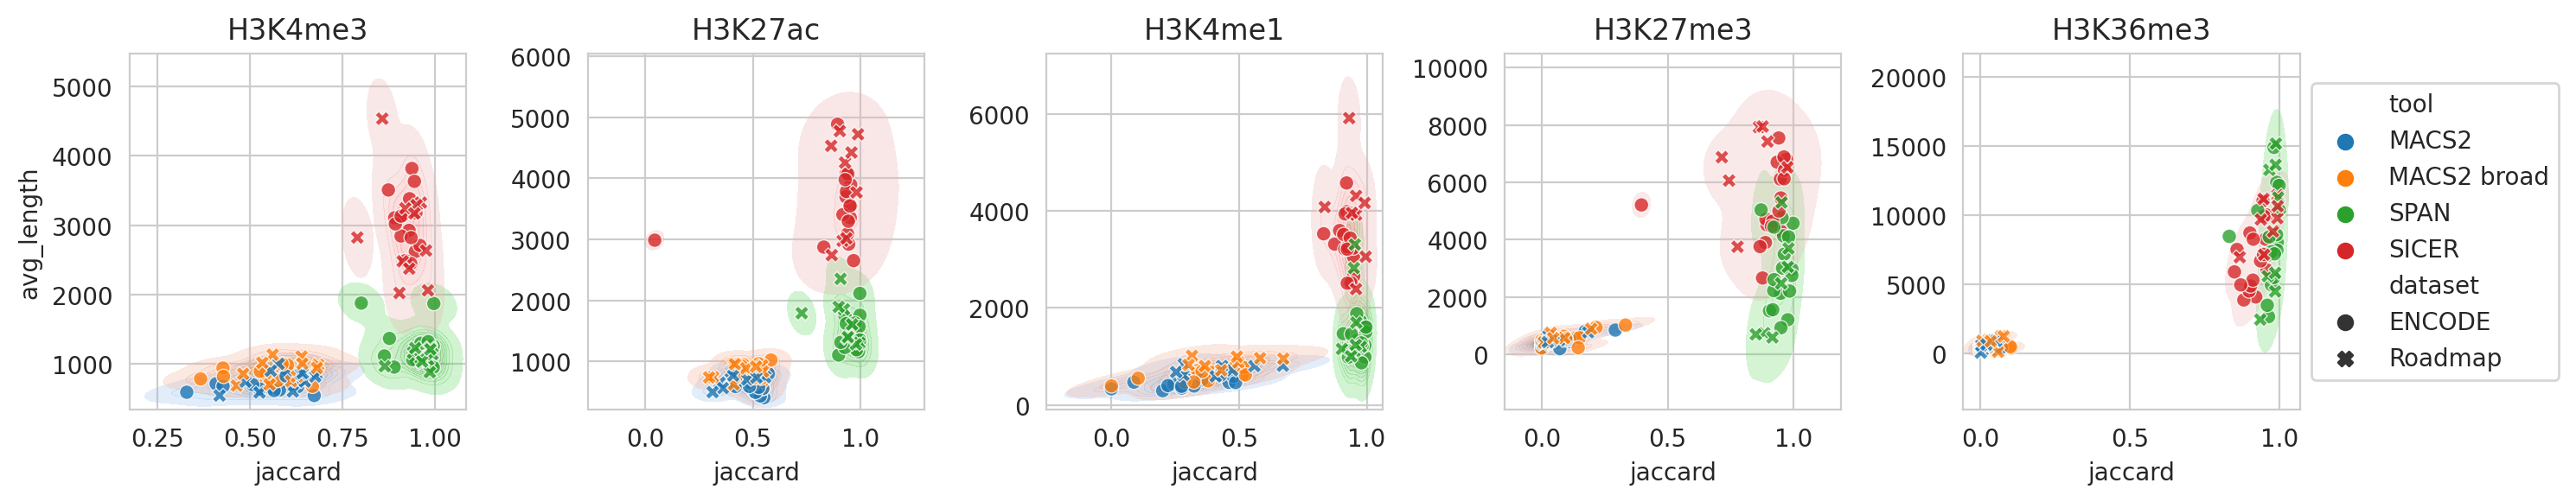

In [26]:
print('ENCODE + Roadmap')
df_jaccard['avg_length'] = (df_jaccard['avg_len_with_control'] + df_jaccard['avg_len_without_control']) / 2
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.kdeplot(df_jaccard[(df_jaccard['modification'] == m)],
                palette=TOOLS_PALETTE,
                hue_order=TOOLS,
                x='jaccard', y='avg_length', hue='tool',
                alpha=0.3,
                thresh=0.01,
                fill=True,
                legend=False,
                ax = ax)
    sns.scatterplot(df_jaccard[(df_jaccard['modification'] == m)],
                    palette=TOOLS_PALETTE,
                    hue_order=TOOLS,
                    style='dataset',
                    x='jaccard', y='avg_length', hue='tool', alpha=0.8,
                    ax = ax)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [27]:
rows = []
for _, (ds, modification, tool, jaccard, avlc, avlwc) in df_jaccard[
    ['dataset', 'modification', 'tool', 'jaccard', 'avg_len_with_control', 'avg_len_without_control']].iterrows():
    rows.append((ds, modification, tool, jaccard, avlc))
    rows.append((ds, modification, tool, jaccard, avlwc))
df_jaccard_avg_len = pd.DataFrame(rows, columns=['dataset', 'modification', 'tool', 'jaccard', 'average_len'])
del rows

In [28]:
# K27me3 outliers HepG2 rep1 and HMEC rep2
df_jaccard[(df_jaccard['dataset'] == 'ENCODE') & (df_jaccard['modification'] == 'H3K27me3') & (df_jaccard['tool']=='SPAN')]

,dataset,modification,cell,replicate,tool,peaks_with_control,peaks_without_control,len_with_control,len_without_control,avg_len_with_control,avg_len_without_control,overlap_len,jaccard,union_len,overlap_diff,avg_length
71,ENCODE,H3K27me3,GM12878,rep1,SPAN,53339,52755,77372660.0,84312939,1450.583251,1598.198067,76792730,0.904584,84892869.0,8100139.0,1524.390659
75,ENCODE,H3K27me3,GM12878,rep2,SPAN,22585,22405,79696380.0,77585100,3528.730573,3462.847579,77162980,0.963111,80118500.0,2955520.0,3495.789076
79,ENCODE,H3K27me3,H1,rep1,SPAN,6279,6219,18597060.0,18568669,2961.786909,2985.796591,18525980,0.993896,18639749.0,113769.0,2973.791750
83,ENCODE,H3K27me3,H1,rep2,SPAN,11471,11385,31545320.0,31478749,2750.006102,2764.931840,31408920,0.993477,31615149.0,206229.0,2757.468971
87,ENCODE,H3K27me3,HMEC,rep1,SPAN,40124,39052,85745660.0,83045299,2137.016748,2126.531266,82161540,0.948425,86629419.0,4467879.0,2131.774007
91,ENCODE,H3K27me3,HMEC,rep2,SPAN,16426,16429,20041500.0,19790010,1220.108365,1204.577881,19685550,0.977146,20145960.0,460410.0,1212.343123
95,ENCODE,H3K27me3,HSMM,rep1,SPAN,34443,34466,51905310.0,55707880,1506.991551,1616.314049,51488280,0.917387,56124910.0,4636630.0,1561.652800
99,ENCODE,H3K27me3,HSMM,rep2,SPAN,53759,52990,115193890.0,122519109,2142.783348,2312.117550,113991020,0.921348,123721979.0,9730959.0,2227.450449
103,ENCODE,H3K27me3,HepG2,rep1,SPAN,30271,28196,156554460.0,138367070,5171.763734,4907.329763,137312500,0.871222,157609030.0,20296530.0,5039.546749
107,ENCODE,H3K27me3,HepG2,rep2,SPAN,24918,25094,114259300.0,114455499,4585.412152,4561.070336,114259300,0.998286,114455499.0,196199.0,4573.241244


# Load BAMS

In [ ]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams

In [ ]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'

df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)


In [ ]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
sns.barplot(data=df_bams, hue='modification', x='dataset', y='reads',
            capsize=.05, errwidth=2, edgecolor="black",
            order=['ENCODE', 'Roadmap'],
            hue_order=MODIFICATIONS + ['Control'],
            ax=ax)
sns.swarmplot(data=df_bams, hue='modification', x='dataset', y='reads',
              dodge=True, size=3, palette='dark:black', alpha=0.5, legend=False,
              order=['ENCODE', 'Roadmap'],
              hue_order=MODIFICATIONS + ['Control'],
              ax=ax)
ax.set_title('Library size')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
rows = []
for (ds, m, c), group in tqdm(
        df_bams[(df_bams['modification'] != 'Control')].groupby(['dataset', 'modification', 'cell'])):
    if len(group) != 2:
        continue
    file1, file2 = group['bam_file'].values[0], group['bam_file'].values[1]
    r1, r2 = group['replicate'].values[0], group['replicate'].values[1]
    cr1 = r1
    # Find control1
    ct = df_bams[(df_bams['modification'] == 'Control') & (df_bams['cell'] == c) &
                 (df_bams['replicate'] == cr1) & (df_bams['dataset'] == ds)]
    if len(ct) == 0:  # Control can be different for Roadmap
        cr1 = ''
        ct = df_bams[(df_bams['modification'] == 'Control') & (df_bams['cell'] == c) &
                     (df_bams['replicate'] == cr1) & (df_bams['dataset'] == ds)]
    if len(ct) == 0:
        continue
    control1 = ct['bam_file'].values[0]
    # Find control1
    cr2 = r2
    ct = df_bams[(df_bams['modification'] == 'Control') & (df_bams['cell'] == c) &
                 (df_bams['replicate'] == cr2) & (df_bams['dataset'] == ds)]
    if len(ct) == 0:  # Control can be different for Roadmap
        cr2 = ''
        ct = df_bams[(df_bams['modification'] == 'Control') & (df_bams['cell'] == c) &
                     (df_bams['replicate'] == cr2) & (df_bams['dataset'] == ds)]
    if len(ct) == 0:
        continue
    control2 = ct['bam_file'].values[0]
    if control1 == control2:
        continue  # Ignore same control for replicates
    rows.append((ds, m, c, r1, file1, cr1, control1, r2, file2, cr2, control2))
df_controls = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell',
                                          'replicate1', 'file1', 'control_replicate1', 'control_file1',
                                          'replicate2', 'file2', 'control_replicate2', 'control_file2'])
df_controls.sample(5)

In [ ]:
t = pd.merge(df_controls, df_peaks[(df_peaks['control']==True)][['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']], 
             left_on=['dataset', 'modification', 'cell', 'replicate1'],
             right_on=['dataset', 'modification', 'cell', 'replicate']
             )
t.rename({'peaks': 'rep1_peaks'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_peaks[df_peaks['control']==True][['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']],
             left_on=['dataset', 'modification', 'cell', 'tool', 'replicate2'],
             right_on=['dataset', 'modification', 'cell', 'tool', 'replicate']
             )
t.rename({'peaks': 'rep2_peaks'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']],
             left_on=['dataset', 'modification', 'cell', 'replicate1'],
             right_on=['dataset', 'modification', 'cell', 'replicate']
             )
t.rename({'reads': 'rep1_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']],
             left_on=['dataset', 'modification', 'cell', 'replicate2'],
             right_on=['dataset', 'modification', 'cell', 'replicate']
             )
t.rename({'reads': 'rep2_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[df_bams['modification'] == 'Control'][['dataset', 'cell', 'replicate', 'reads']], 
             left_on=['dataset', 'cell', 'control_replicate1'],
             right_on=['dataset', 'cell', 'replicate']
             )
t.rename({'reads': 'rep1_ctrl_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[df_bams['modification'] == 'Control'][['dataset', 'cell', 'replicate', 'reads']],
             left_on=['dataset', 'cell', 'control_replicate2'],
             right_on=['dataset', 'cell', 'replicate']
             )
t.rename({'reads': 'rep2_ctrl_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)

t.head(5)

In [ ]:
sns.set_theme(style='white')
for tool in TOOLS:
    print(tool)
    plt.figure(figsize=(24, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        ax.set_title(m)
        tt = t[(t['dataset'] == 'ENCODE') & (t['modification'] == m) & (t['tool'] == tool)]
        rep1_peaks, rep1_reads, rep1_ctrl_reads = tt['rep1_peaks'], tt['rep1_reads'], tt['rep1_ctrl_reads'] 
        rep2_peaks, rep2_reads, rep2_ctrl_reads = tt['rep2_peaks'], tt['rep2_reads'], tt['rep2_ctrl_reads']
        minx = min(np.min(rep1_reads), np.min(rep2_reads))
        maxx = max(np.max(rep1_reads), np.max(rep2_reads))
        miny = min(np.min(rep1_ctrl_reads), np.min(rep2_ctrl_reads))
        maxy = max(np.max(rep1_ctrl_reads), np.max(rep2_ctrl_reads))
        minxy = min(minx, miny)
        maxxy = max(maxx, maxy)
        sns.lineplot(x=[minxy, maxxy], y=[minxy, maxxy], color='grey', ax=ax, alpha=0.5, linestyle='dotted')
        sns.scatterplot(x=rep1_reads.to_list() + rep2_reads.to_list(), 
                        y=rep1_ctrl_reads.to_list() + rep2_ctrl_reads.to_list(), 
                        alpha=0.8, ax = ax, 
                        size=rep1_peaks.to_list() + rep2_peaks.to_list(), 
                        color='blue')
        for r1r, r1cr, r2r, r2cr in zip(rep1_reads, rep1_ctrl_reads, rep2_reads, rep2_ctrl_reads):
            sns.lineplot(x=[r1r, r2r], y=[r1cr, r2cr], color='green', ax=ax, alpha=0.5, linestyle='dotted')
        for xv, yv, cell, rep in zip(rep1_reads, rep1_ctrl_reads, t['cell'], t['replicate1']):
            rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
            ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
        for xv, yv, cell, rep in zip(rep2_reads, rep2_ctrl_reads, t['cell'], t['replicate2']):
            rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
            ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
        offset = 0.1 * (maxxy - minxy)
        ax.set_xlabel('Signal reads')
        ax.set_ylabel('Control reads')
        ax.set_xlim(minxy - offset, maxxy + offset)
        ax.set_ylim(minxy - offset, maxxy + offset)
        if i > 0:
            ax.set_ylabel(None)
        # if i < len(axs) - 1:
        #     ax.legend().set_visible(False)
        # else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()
sns.set_theme(style='whitegrid')

# Compare replicates

In [29]:
def compute_reps_peaks(df_peaks, modifications, cells):
    rows = []
    t = df_peaks[(df_peaks['modification'].isin(modifications)) & (df_peaks['cell'].isin(cells))]
    for (ds, m, c, to), group in t.groupby(['dataset', 'modification', 'cell', 'tool']):
        if len(group) != 2:
            continue
        group.sort_values(by='replicate', inplace=True)
        rep1, rep2 = group['replicate'].values[0], group['replicate'].values[1]
        peaks1, peaks2 = group['peaks'].values[0], group['peaks'].values[1]
        rows.append((ds, m, c, to, rep1, rep2, peaks1, peaks2))
    return pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'tool', 'replicate1', 'replicate2', 'peaks1', 'peaks2'])

In [30]:
df_encode_peaks_original = df_peaks[(df_peaks['dataset'] == 'ENCODE') & (df_peaks['control'] == True)].copy()

In [31]:
df_encode_reps = compute_reps_peaks(df_encode_peaks_original, MODIFICATIONS, GSE26320_CELLS)
df_encode_reps.sample(5)

,dataset,modification,cell,tool,replicate1,replicate2,peaks1,peaks2
21,ENCODE,H3K27ac,K562,MACS2 broad,rep1,rep2,52028,37218
106,ENCODE,H3K4me1,H1,SICER,rep1,rep2,51468,76646
25,ENCODE,H3K27ac,NHEK,MACS2 broad,rep1,rep2,55028,54766
40,ENCODE,H3K27me3,HMEC,MACS2,rep1,rep2,2382,4999
105,ENCODE,H3K4me1,H1,MACS2 broad,rep1,rep2,48462,62


ENCODE


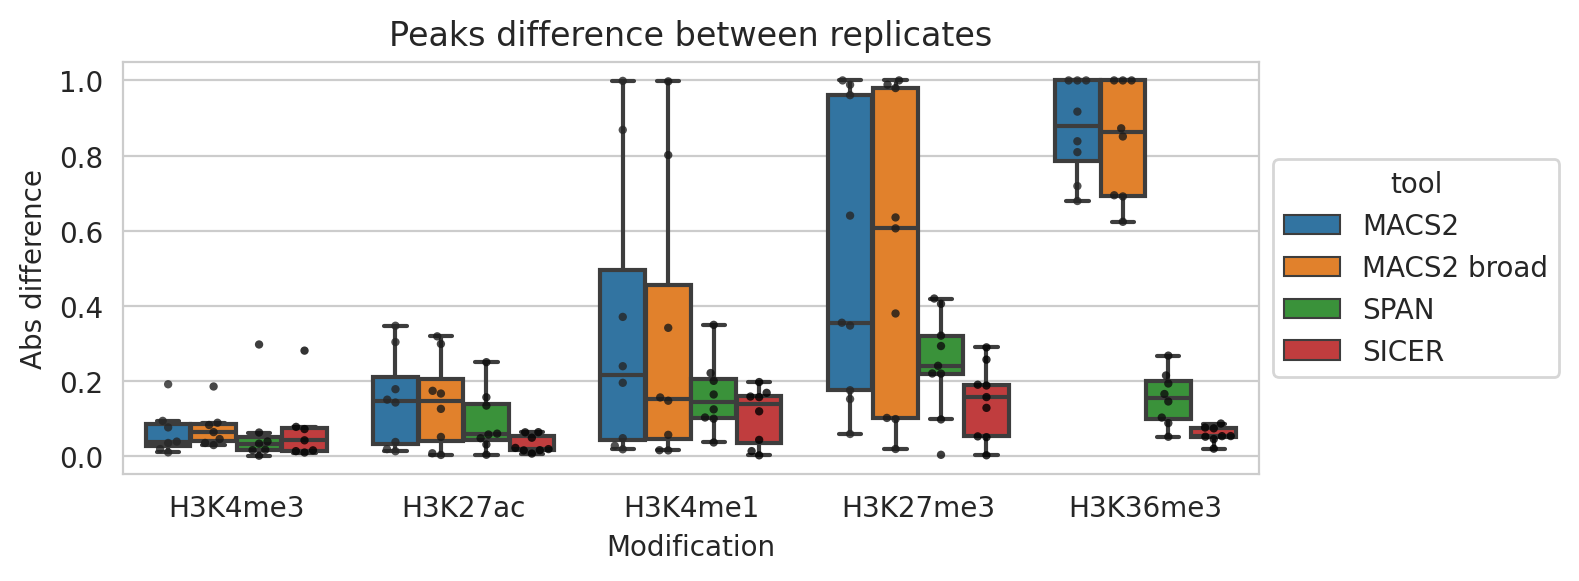

In [32]:
print('ENCODE')
df_encode_reps['reps_peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                            (df_encode_reps['peaks1'] + df_encode_reps['peaks2']))
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_encode_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates')
ax.set_ylabel('Abs difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [33]:
df_immune_peaks_original = df_peaks[(df_peaks['dataset'] == 'Roadmap') & (df_peaks['control'] == True)].copy()
df_immune_reps = compute_reps_peaks(df_immune_peaks_original, MODIFICATIONS, IMMUNE_CELLS)
df_immune_reps.sample(5)

,dataset,modification,cell,tool,replicate1,replicate2,peaks1,peaks2
30,Roadmap,H3K4me1,CD4,SICER,,rep1,58199,38267
25,Roadmap,H3K4me1,CD34,MACS2 broad,,rep2,140715,136538
36,Roadmap,H3K4me3,CD4ABT,MACS2,rep1,rep2,25997,32717
18,Roadmap,H3K36me3,CD34,SICER,,rep1,38823,27445
43,Roadmap,H3K4me3,TCellBB,SPAN,rep1,rep2,22221,23958


Roadmap


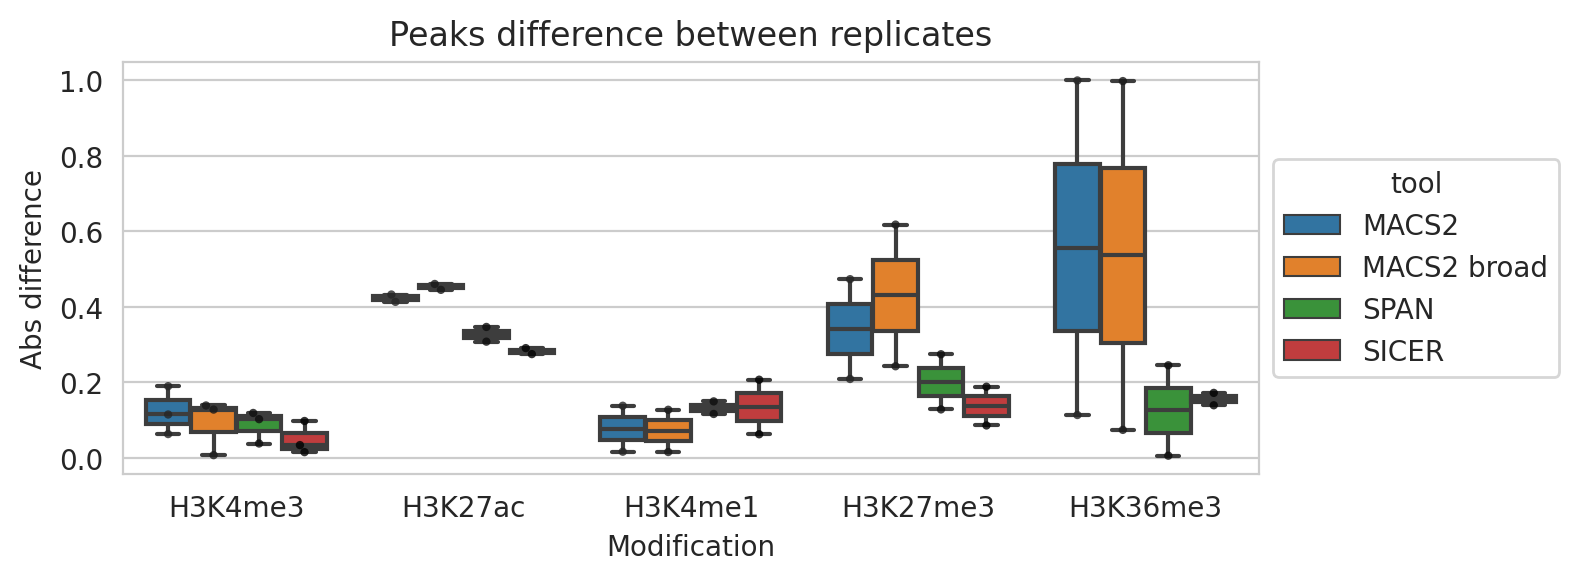

In [34]:
print('Roadmap')
df_immune_reps['reps_peaks_diff'] = np.fabs((df_immune_reps['peaks1'] - df_immune_reps['peaks2']) /
                                            (df_immune_reps['peaks1'] + df_immune_reps['peaks2']))
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_immune_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates')
ax.set_ylabel('Abs difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE + Roadmap


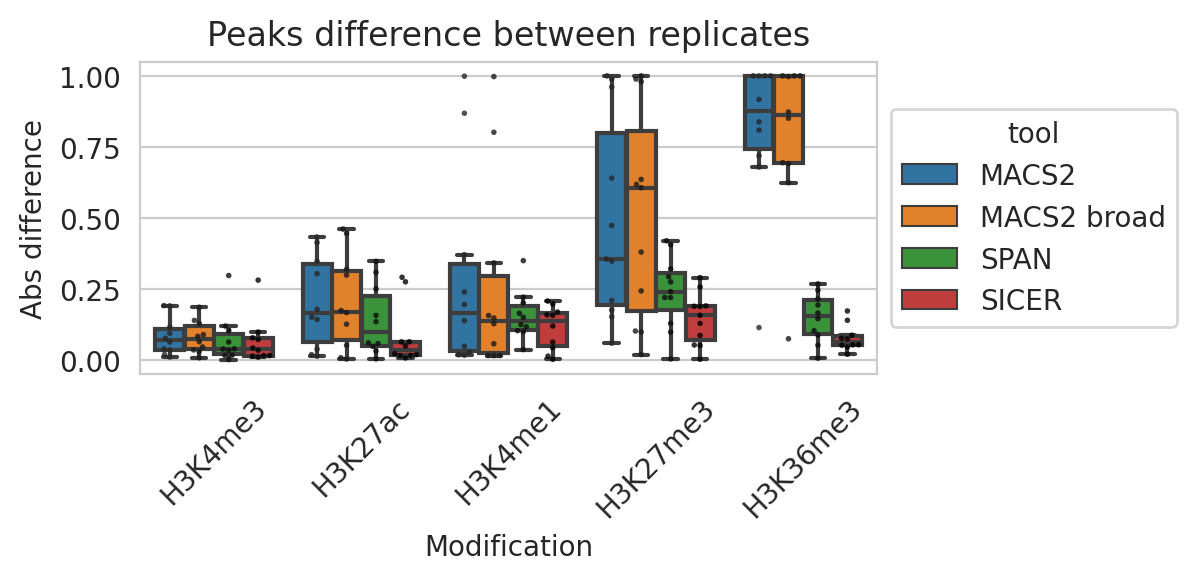

In [35]:
print('ENCODE + Roadmap')
t = pd.concat([df_encode_reps, df_immune_reps]).reset_index(drop=True)
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=2, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates')
ax.set_ylabel('Abs difference')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE + Roadmap NO SPAN


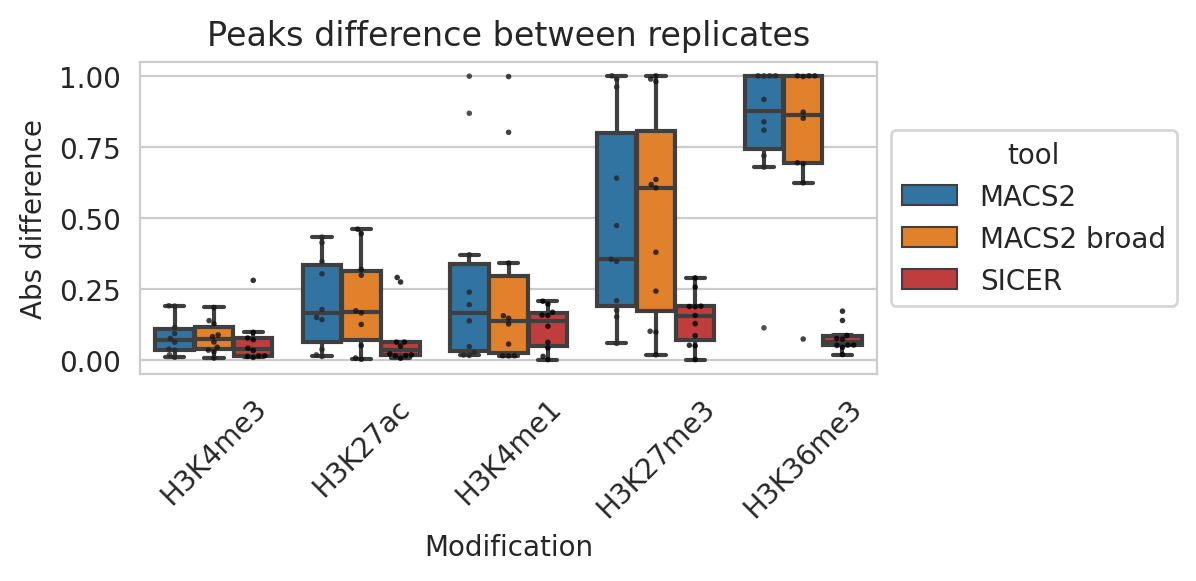

In [36]:
print('ENCODE + Roadmap NO SPAN')
t = pd.concat([df_encode_reps, df_immune_reps]).reset_index(drop=True)
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=2, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates')
ax.set_ylabel('Abs difference')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# SWAP controls

In [ ]:
# Swap controls in replicates
SWAP_CONTROL_DIR = os.path.expanduser('~/data/2024_swap_control')
! mkdir -p {SWAP_CONTROL_DIR}/bams

In [ ]:
# for _, (ds, m, c, r1, file1, cr1, control1, r2, file2, cr2, control2) in df_controls[
#     ['dataset', 'modification', 'cell',
#      'replicate1', 'file1', 'control_replicate1', 'control_file1',
#      'replicate2', 'file2', 'control_replicate2', 'control_file2']].iterrows():
#     print(ds, m, c)
#     print(r1, file1, cr1, control1)
#     print(r2, file2, cr2, control2)
# 
#     # Keep same signal
#     ! ln -sf {file1} {SWAP_CONTROL_DIR}/bams/{ds}_{m}_{c}_{r1}.bam
#     ! ln -sf {file2} {SWAP_CONTROL_DIR}/bams/{ds}_{m}_{c}_{r2}.bam
#     # Swap controls
#     ! ln -sf {control1} {SWAP_CONTROL_DIR}/bams/{ds}_Control_{c}_{r2}_swap.bam
#     ! ln -sf {control2} {SWAP_CONTROL_DIR}/bams/{ds}_Control_{c}_{r1}_swap.bam

## Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" span=True sicer=True span_bin=100 span_params="--keep-cache --debug" --rerun-trigger mtime; 

```

In [ ]:
df_swapped = load_peaks_path(SWAP_CONTROL_DIR, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS,
                             GSE26320_REPS + IMMUNE_REPS)
df_swapped['dataset'] = ['ENCODE' if 'ENCODE' in f else 'Roadmap' for f in df_swapped['file']]
df_swapped.sample(5)

In [ ]:
plt.figure(figsize=(10, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',
                # showfliers=False,
                capsize=.2, errwidth=2, edgecolor="black",
                palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_swapped[df_swapped['modification'] == m], x='tool', y='peaks',
                  size=2, alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    # ax.set_ylim(0, 1)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Diff vs original peaks

In [ ]:
t = pd.concat([df_encode_peaks_original, df_immune_peaks_original]).reset_index(drop=True)
t = pd.merge(df_swapped,
             t[['file', 'modification', 'cell', 'replicate', 'peaks', 'tool']],
             on=['modification', 'cell', 'replicate', 'tool'],
             suffixes=('_swapped', '_original'),
             how='inner')
t['original_swap_peaks_diff'] = t['peaks_swapped'] - t['peaks_original']
t['original_swap_peaks_diff_abs'] = np.fabs(t['original_swap_peaks_diff'])

t['original_swap_peaks_diff_relative'] = [(ps - po) / (ps + po) for _, (ps, po) in
                                          t[['peaks_swapped', 'peaks_original']].iterrows()]
t['original_swap_peaks_diff_relative_abs'] = np.fabs(t['original_swap_peaks_diff_relative'])
t.sample(5)

In [ ]:
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='original_swap_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='original_swap_peaks_diff',
              dodge=True, size=2, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between swapped and original control')
ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='original_swap_peaks_diff_abs',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='original_swap_peaks_diff_abs',
              dodge=True, size=2, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between swapped and original control')
ax.set_ylabel('Abs difference')
# ax.set(yscale='log')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='original_swap_peaks_diff_relative_abs',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='original_swap_peaks_diff_relative_abs',
              dodge=True, size=2, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference in swapped/original control')
ax.set_ylabel('Abs difference')
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='original_swap_peaks_diff_relative_abs',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='original_swap_peaks_diff_relative_abs',
              dodge=True, size=2, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference in swapped/original control')
ax.set_ylabel('abs difference')
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## Compare difference between replicates in original vs swapped dataset

In [ ]:
df_swapped_reps = compute_reps_peaks(df_swapped, MODIFICATIONS, GSE26320_CELLS + IMMUNE_CELLS)
df_swapped_reps['reps_peaks_diff'] = np.fabs((df_swapped_reps['peaks1'] - df_swapped_reps['peaks2']) /
                                             (df_swapped_reps['peaks1'] + df_swapped_reps['peaks2']))

df_swapped_reps.sample(5)

In [ ]:
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_swapped_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_swapped_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between reps swapped controls')
ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
df_swapped_reps['swapped_reps_peaks_diff'] = \
    (df_swapped_reps['peaks1'] - df_swapped_reps['peaks2']) / (df_swapped_reps['peaks1'] + df_swapped_reps['peaks2'])
df_encode_reps['original_reps_peaks_diff'] = \
    (df_encode_reps['peaks1'] - df_encode_reps['peaks2']) / (df_encode_reps['peaks1'] + df_encode_reps['peaks2'])
t = pd.merge(df_swapped_reps, df_encode_reps, on=['modification', 'cell', 'tool', 'replicate1', 'replicate2'])

for tool in TOOLS:
    print(tool)
    plt.figure(figsize=(10, 2))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        tt = t[(t['modification'] == m) & (t['tool'] == tool)]
        sns.scatterplot(
            tt, x='original_reps_peaks_diff', y='swapped_reps_peaks_diff',
            ax=ax)
        sns.lineplot(x=[-1.1, 1.1], y=[1.0, -1.0], color='black', ax=ax, alpha=0.5, linestyle='dotted')
        ax.title.set_text(m)
        ax.set_xlabel('original diff')
        ax.set_ylabel('swap diff')
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
    plt.tight_layout()
    plt.show()

# Recompute MACS2 with --scale-to=large option

```
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory `pwd` --config genome=hg38 fastq_dir=`pwd` start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True macs2_params="--scale-to=large --q=0.05" macs2_suffix="q0.05_large" --rerun-trigger mtime --rerun-incomplete;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory `pwd` --config genome=hg38 fastq_dir=`pwd` start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1 --scale-to=large" macs2_suffix="broad0.1_large"  --rerun-trigger mtime; 
mkdir macs2_large
mv macs2/*large* macs2_large/
```

In [ ]:
t1 = load_peaks(os.path.join(GSE26320_PATH, 'macs2_large'), '.narrowPeak', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
t1['tool'] = 'MACS2'
t2 = load_peaks(os.path.join(GSE26320_PATH, 'macs2_large'), '.broadPeak', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
t2['tool'] = 'MACS2 broad'
df_macs2_large = pd.concat([t1, t2]).reset_index(drop=True)
df_macs2_large['dataset'] = 'ENCODE'
print('MACS2', len(df_macs2_large))

In [ ]:
df_peaks_macs2_large = pd.concat([df_macs2_large, df_peaks[(df_peaks['dataset'] == 'ENCODE') & 
                                                          (df_peaks['control'] == True) & 
                                                          (df_peaks['tool'].isin(['SPAN', 'SICER']))]]).reset_index(drop=True)
df_peaks_macs2_large.sample(5)

In [ ]:
# Remove outliers, see 2023 - figures.ipynb
OUTLIERS = [('H3K4me3', 'NK', ''),
            ('H3K4me1', 'NK', ''),
            ('H3K27me3', 'TCell', ''),
            ('H3K27me3', 'NHLF', 'rep2'),
            ('H3K27me3', 'GM12878', 'rep1')]

df_peaks_macs2_large = df_peaks_macs2_large.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_peaks_macs2_large[['modification', 'cell', 'replicate']].iterrows()]].copy()
df_peaks_macs2_large.sample(3)

In [ ]:
plt.figure(figsize=(10, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks_macs2_large[df_peaks_macs2_large['modification'] == m], x='tool', y='peaks',
                # showfliers=False,
                capsize=.2, errwidth=2, edgecolor="black",
                palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_peaks_macs2_large[df_peaks_macs2_large['modification'] == m], x='tool', y='peaks',
                  size=3, palette='dark:black', alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    # ax.set_ylim(0, 1)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Compare replicates

In [ ]:
df_macs2_large_reps = compute_reps_peaks(df_peaks_macs2_large, MODIFICATIONS, GSE26320_CELLS)
df_macs2_large_reps['reps_peaks_diff'] = np.fabs((df_macs2_large_reps['peaks1'] - df_macs2_large_reps['peaks2']) /
                                                 (df_macs2_large_reps['peaks1'] + df_macs2_large_reps['peaks2']))
df_macs2_large_reps.sample(5)

In [ ]:
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_macs2_large_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_macs2_large_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates --scale-to=large')
# ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
t = pd.merge(df_controls, df_peaks_macs2_large[['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']],
             left_on=['dataset', 'modification', 'cell', 'replicate1'],
             right_on=['dataset', 'modification', 'cell', 'replicate']
             )
t.rename({'peaks': 'rep1_peaks'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_peaks_macs2_large[['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']],
             left_on=['dataset', 'modification', 'cell', 'tool', 'replicate2'],
             right_on=['dataset', 'modification', 'cell', 'tool', 'replicate']
             )
t.rename({'peaks': 'rep2_peaks'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']],
             left_on=['dataset', 'modification', 'cell', 'replicate1'],
             right_on=['dataset', 'modification', 'cell', 'replicate']
             )
t.rename({'reads': 'rep1_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']],
             left_on=['dataset', 'modification', 'cell', 'replicate2'],
             right_on=['dataset', 'modification', 'cell', 'replicate']
             )
t.rename({'reads': 'rep2_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[df_bams['modification'] == 'Control'][['dataset', 'cell', 'replicate', 'reads']],
             left_on=['dataset', 'cell', 'control_replicate1'],
             right_on=['dataset', 'cell', 'replicate']
             )
t.rename({'reads': 'rep1_ctrl_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)
t = pd.merge(t, df_bams[df_bams['modification'] == 'Control'][['dataset', 'cell', 'replicate', 'reads']],
             left_on=['dataset', 'cell', 'control_replicate2'],
             right_on=['dataset', 'cell', 'replicate']
             )
t.rename({'reads': 'rep2_ctrl_reads'}, axis=1, inplace=True)
t.drop('replicate', axis=1, inplace=True)

t.head(5)

In [ ]:
sns.set_theme(style='white')
for tool in ['MACS2', 'MACS2 broad']:
    print(tool, 'large')
    plt.figure(figsize=(24, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        ax.set_title(m)
        tt = t[(t['dataset'] == 'ENCODE') & (t['modification'] == m) & (t['tool'] == tool)]
        rep1_peaks, rep1_reads, rep1_ctrl_reads = tt['rep1_peaks'], tt['rep1_reads'], tt['rep1_ctrl_reads']
        rep2_peaks, rep2_reads, rep2_ctrl_reads = tt['rep2_peaks'], tt['rep2_reads'], tt['rep2_ctrl_reads']
        minx = min(np.min(rep1_reads), np.min(rep2_reads))
        maxx = max(np.max(rep1_reads), np.max(rep2_reads))
        miny = min(np.min(rep1_ctrl_reads), np.min(rep2_ctrl_reads))
        maxy = max(np.max(rep1_ctrl_reads), np.max(rep2_ctrl_reads))
        minxy = min(minx, miny)
        maxxy = max(maxx, maxy)
        sns.lineplot(x=[minxy, maxxy], y=[minxy, maxxy], color='grey', ax=ax, alpha=0.5, linestyle='dotted')
        sns.scatterplot(x=rep1_reads.to_list() + rep2_reads.to_list(),
                        y=rep1_ctrl_reads.to_list() + rep2_ctrl_reads.to_list(),
                        alpha=0.8, ax = ax,
                        size=rep1_peaks.to_list() + rep2_peaks.to_list(),
                        color='blue')
        for r1r, r1cr, r2r, r2cr in zip(rep1_reads, rep1_ctrl_reads, rep2_reads, rep2_ctrl_reads):
            sns.lineplot(x=[r1r, r2r], y=[r1cr, r2cr], color='green', ax=ax, alpha=0.5, linestyle='dotted')
        for xv, yv, cell, rep in zip(rep1_reads, rep1_ctrl_reads, t['cell'], t['replicate1']):
            rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
            ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
        for xv, yv, cell, rep in zip(rep2_reads, rep2_ctrl_reads, t['cell'], t['replicate2']):
            rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
            ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
        offset = 0.1 * (maxxy - minxy)
        ax.set_xlabel('Signal reads')
        ax.set_ylabel('Control reads')
        ax.set_xlim(minxy - offset, maxxy + offset)
        ax.set_ylim(minxy - offset, maxxy + offset)
        if i > 0:
            ax.set_ylabel(None)
        # if i < len(axs) - 1:
        #     ax.legend().set_visible(False)
        # else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()
sns.set_theme(style='whitegrid')